In [287]:
# test in evaluation metrics
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, make_scorer, confusion_matrix, log_loss, roc_curve, auc, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

shap.initjs()
import xgboost
import shap
from sklearn.feature_extraction.text import TfidfVectorizer

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

roc_curve
%matplotlib inline

In [162]:
cleaned_df = pd.read_csv('data/cleaned_df.csv')

In [163]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
min_samples_splits = np.linspace(1e-4,1,11, endpoint=True)
min_samples_leafs = np.linspace(1e-4,0.5,10, endpoint=True)
est_list = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
learning_rate_list = np.logspace(-10,10,11, endpoint=True)
learning_rate_list1 = np.linspace(0.1,1,11, endpoint=True)


In [164]:
pd.set_option("display.max_rows", 50, "display.max_columns", 50)

In [165]:
countries = ['australia', 'canada', 'denmark', 'france', 'germany', 'italy', 'norway', 'spain', 'united-kingdom', 'united-states']

# Codebook

In [166]:
df_q = pd.read_excel('codebook.xlsx')

In [167]:
df_q.loc[0:50]

RecordNo   Unnamed: 1 Unnamed: 2
0                   NaN          NaN      Value
1   Standard Attributes        Label   RecordNo
2                   NaN         Type    Numeric
3                   NaN  Measurement    Nominal
4                   NaN          NaN        NaN
..                  ...          ...        ...
46                  NaN           31    week 31
47                  NaN           32    week 32
48                  NaN           33    week 33
49                  NaN           34    week 34
50                  NaN           35    week 35

[51 rows x 3 columns]

In [168]:
#df_q.drop(df_q.index[:67], inplace=True)

In [169]:
df_q.dropna(axis=0, subset=['RecordNo'], inplace=True) 

In [170]:
df_q.reset_index(drop=True, inplace=True)

In [171]:
for index, row in df_q.iterrows():
    if pd.isna(row['Unnamed: 2']) == True:
        df_q.iloc[index]['Unnamed: 2'] = df_q.iloc[index+1]['Unnamed: 2']

In [172]:
df_q=df_q[df_q['RecordNo'] != 'Standard Attributes']

In [173]:
df_q=df_q[df_q['RecordNo'] != 'Valid Values']

In [174]:
df_q.drop('Unnamed: 1', axis=1, inplace=True)

In [175]:
df_q.reset_index(drop=True, inplace=True)

In [176]:
df_q.rename(columns = {'RecordNo':'code', 'Unnamed: 2': 'question'}, inplace = True)
df_q

code  \
0                         endtime   
1                           qweek   
2                       i1_health   
3                       i2_health   
4                      i7a_health   
..                            ...   
507  Multiple Response Categories   
508                    $child_age   
509  Multiple Response Categories   
510                         $WAH7   
511  Multiple Response Categories   

                                              question  
0       When did you complete this qx (epoch seconds)?  
1    THIS IS SHOWN ONLY IN TEST MODE, PLEASE UPDATE...  
2    About how many people from your household have...  
3    Not including those people in your household, ...  
4    How many times did you leave your home yesterd...  
..                                                 ...  
507                I'm not eligible to receive one yet  
508  In which, if any, any of the following age gro...  
509                                              0 - 2  
510  If you are likely to further away from the cen...  
511                       For a better quality of life  

[512 rows x 2 columns]

In [177]:
code_dict={}
for index, row in df_q.iterrows():
    code = row['code']
    q = row['question']
    code_dict[code]=q
code_dict

{'endtime': 'When did you complete this qx (epoch seconds)?',
 'qweek': 'THIS IS SHOWN ONLY IN TEST MODE, PLEASE UPDATE THIS VARIABLE BEFORE LAUNCH',
 'i1_health': 'About how many people from your household have you come into physical contact with (within 2 meters / 6 feet)?',
 'i2_health': 'Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?',
 'i7a_health': 'How many times did you leave your home yesterday?  If you are not staying at home, how many times did you leave where you are staying yesterday?',
 'i3_health': 'In the last 7 days, have you personally been tested for coronavirus (COVID-19?)',
 'i4_health': 'In the last 7 days, has someone in your household been tested for coronavirus (COVID-19)?',
 'i5_health_1': 'Dry cough',
 'i5_health_2': 'Fever',
 'i5_health_3': 'Loss of sense of smell',
 'i5_health_4': 'Loss of sense of taste',
 'i5_health_5': 'Shortness of breath or difficulty breathing',


# Open and work out nans

In [95]:
emp_dict={
'employment_status_1': 'Full time employment',
'employment_status_2': 'Part time employment',
'employment_status_3': 'Full time student',
'employment_status_4': 'Retired',
'employment_status_5': 'Unemployed',
'employment_status_6': 'Not working',
'employment_status_7': 'Other'
}


In [20]:
def emp_helper(df):
    for index, row in df.iterrows():
        for k in emp_dict:
            if row[k] == 'Yes':
                df.loc[index, 'employment_status'] = emp_dict[k]
    drop_list=list(emp_dict.keys())
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [83]:
def make_df_dict(code_list=False, dropna_cols=False):
    dataframe_country_dict = {}
    for country in countries:
        file_name=f'data/{country}.csv'
        print(country)
        df = pd.read_csv(file_name, low_memory=False, na_values=' ')
        if country == 'denmark' or country == 'norway':
            df["employment_status"] = ""
            df = emp_helper(df)
        if code_list:
            df=df[code_list]
        if dropna_cols:
            df = df.dropna(subset=dropna_cols)
        df['Country'] = country
        dataframe_country_dict[country] = df
    conc_df = pd.concat(dataframe_country_dict.values())
    return conc_df

In [334]:
conc_df = make_df_dict()

australia
canada
denmark
france
germany
italy
norway
spain
united-kingdom
united-states


In [58]:
def nan_col_sorted(df):
    col_nans={}
    for col in df.columns:
        no_nans=df[col].isnull().sum()
        try:
            written_code=f'{col}~{code_dict[col]}'
        except:
            written_code='RecordNo'
        col_nans[written_code] = no_nans
    sortlist = sorted(col_nans.items(), key=lambda x:x[1])
    sortdict = dict(sortlist)
    return sortdict

In [335]:
nan_col_sorted(conc_df)

{'endtime~When did you complete this qx (epoch seconds)?': 0,
 'qweek~THIS IS SHOWN ONLY IN TEST MODE, PLEASE UPDATE THIS VARIABLE BEFORE LAUNCH': 0,
 'weight~Weight': 0,
 'age~What is your age?': 0,
 'gender~Gender': 0,
 'i14_health_other~i14healthother': 18,
 'i12_health_3~Used hand sanitiser': 49,
 'i12_health_14~Avoided large-sized social gatherings (more than 10 people)': 53,
 'i12_health_13~Avoided medium-sized social gatherings (between 3 and 10 people)': 54,
 'i2_health~Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?': 59,
 'i12_health_1~Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)': 59,
 'i12_health_15~Avoided crowded areas': 60,
 'i12_health_16~Avoided going to shops': 60,
 'i12_health_6~Avoided going out in general': 61,
 'i12_health_12~Avoided small social gatherings (not more than 2 people)': 62,
 'i12_health_4~Covered

In [336]:
key_df = conc_df.copy()
key_df = key_df.dropna(subset=['PHQ4_2', 'vac2_2', 'vac', 'employment_status', 'd1_health_3'])
key_df_nan_dict = nan_col_sorted(key_df)
key_df_nan_dict

{'endtime~When did you complete this qx (epoch seconds)?': 0,
 'qweek~THIS IS SHOWN ONLY IN TEST MODE, PLEASE UPDATE THIS VARIABLE BEFORE LAUNCH': 0,
 'i2_health~Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?': 0,
 'i9_health~Thinking about the next 7 days… would you isolate yourself after feeling unwell or having any of the following new symptoms: a dry cough, fever, loss of sense of smell, loss of sense of taste, shortness of breath or difficulty breathing?': 0,
 'i11_health~If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?': 0,
 'i12_health_1~Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)': 0,
 'i12_health_2~Washed hands with soap and water': 0,
 'i12_health_3~Used hand sanitiser': 0,
 'i12_health_4~Covered your nose and mouth whe

In [337]:
codes_no_nans = {k:v for k, v in key_df_nan_dict.items() if v<100}

In [338]:
codes_no_nans

{'endtime~When did you complete this qx (epoch seconds)?': 0,
 'qweek~THIS IS SHOWN ONLY IN TEST MODE, PLEASE UPDATE THIS VARIABLE BEFORE LAUNCH': 0,
 'i2_health~Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?': 0,
 'i9_health~Thinking about the next 7 days… would you isolate yourself after feeling unwell or having any of the following new symptoms: a dry cough, fever, loss of sense of smell, loss of sense of taste, shortness of breath or difficulty breathing?': 0,
 'i11_health~If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?': 0,
 'i12_health_1~Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)': 0,
 'i12_health_2~Washed hands with soap and water': 0,
 'i12_health_3~Used hand sanitiser': 0,
 'i12_health_4~Covered your nose and mouth whe

In [75]:
final_code_dict = {'i2_health~Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?': 0,
 'i11_health~If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?': 0,
 'i12_health_1~Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)': 0,
 'i12_health_2~Washed hands with soap and water': 0,
 'i12_health_3~Used hand sanitiser': 0,
 'i12_health_4~Covered your nose and mouth when sneezing or coughing': 0,
 'i12_health_5~Avoided contact with people who have symptoms or you think may have been exposed to the coronavirus': 0,
 'i12_health_6~Avoided going out in general': 0,
 'i12_health_7~Avoided going to hospital or other healthcare settings': 0,
 'i12_health_8~Avoided taking public transport': 0,
 'i12_health_11~Avoided having guests to your home': 0,
 'i12_health_12~Avoided small social gatherings (not more than 2 people)': 0,
 'i12_health_14~Avoided large-sized social gatherings (more than 10 people)': 0,
 'd1_health_1~Arthritis': 0,
 'd1_health_2~Asthma': 0,
 'd1_health_3~Cancer': 0,
 'd1_health_4~Cystic fibrosis': 0,
 'd1_health_5~Chronic obstructive pulmonary disease (COPD)': 0,
 'd1_health_6~Diabetes': 0,
 'd1_health_7~Epilepsy': 0,
 'd1_health_8~Heart disease': 0,
 'd1_health_9~High blood pressure': 0,
 'd1_health_10~High cholesterol': 0,
 'd1_health_11~HIV/ Aids': 0,
 'd1_health_13~Multiple Sclerosis': 0,
 'weight~Weight': 0,
 'age~What is your age?': 0,
 'gender~Gender': 0,
 'household_size~Number of people in household': 0,
 'employment_status~Employment Status': 0,
 'WCRex2~And how much confidence do you have in the NHS to respond to a Coronavirus (COVID-19) outbreak in the UK?': 0,
 'PHQ4_2~Feeling down, depressed, or hopeless': 0,
 'WCRex1~How well or badly do you think the Government are handling the issue of the Coronavirus (COVID-19)?': 0,
 'r1_1~Coronavirus (COVID-19) is very dangerous for me': 0,
 'r1_2~It is likely that I will get coronavirus (COVID-19) in the future': 0,
 'r1_6~I feel it is important to carry out activities which will improve my health': 0,
 'r1_7~My life has been greatly affected by coronavirus (COVID-19)': 0,
 'vac2_1~I am worried about getting COVID19': 0,
 'vac2_2~I am worried about potential side effects of a COVID19 vaccine': 0,
 'vac2_3~I believe government health authorities in my country will provide me with an effective COVID19 vaccine': 0,
 'vac7~How much do you trust COVID-19 vaccines?': 0,
 'r1_8~Getting a vaccine will protect me against coronavirus (COVID-19)': 0,
 'r1_9~Getting a vaccine will protect others against coronavirus (COVID-19)': 0,
 'vac2_7~A vaccine for coronavirus (COVID-19) will protect me against any variants, strains or mutations of coronavirus': 0,
 'vac~Have you had the first or second doses of a Coronavirus (COVID-19) vaccine?': 0}

In [106]:
final_code_list = ['qweek']
for k in final_code_dict:
    split_list = k.split('~')
    final_code_list.append(split_list[0])
final_code_list    

['qweek',
 'i2_health',
 'i11_health',
 'i12_health_1',
 'i12_health_2',
 'i12_health_3',
 'i12_health_4',
 'i12_health_5',
 'i12_health_6',
 'i12_health_7',
 'i12_health_8',
 'i12_health_11',
 'i12_health_12',
 'i12_health_14',
 'd1_health_1',
 'd1_health_2',
 'd1_health_3',
 'd1_health_4',
 'd1_health_5',
 'd1_health_6',
 'd1_health_7',
 'd1_health_8',
 'd1_health_9',
 'd1_health_10',
 'd1_health_11',
 'd1_health_13',
 'weight',
 'age',
 'gender',
 'household_size',
 'employment_status',
 'WCRex2',
 'PHQ4_2',
 'WCRex1',
 'r1_1',
 'r1_2',
 'r1_6',
 'r1_7',
 'vac2_1',
 'vac2_2',
 'vac2_3',
 'vac7',
 'r1_8',
 'r1_9',
 'vac2_7',
 'vac']

In [341]:
na_cols = ['PHQ4_2', 'vac2_2', 'vac', 'employment_status', 'd1_health_3']
no_nan_df = make_df_dict(code_list=final_code_list, dropna_cols=na_cols)

australia
canada
denmark
france
germany
italy
norway
spain
united-kingdom
united-states


In [342]:
no_nan_df.reset_index(drop=True, inplace=True)

# Apply 

## qweek

In [344]:
no_nan_df['qweek'] = no_nan_df['qweek'].apply(lambda x: x[5:])

## households

In [345]:
hh_dict={1.0: 1, 2.0:2, 3.0:3, 4.0:4, 5.0:5, 6.0:6, 7.0:7, 8.0:8,
         '1':1,'2':2, '3':3, '4':4, '5':5, '6':6, '7':7.0, '8 or more':8.0,
         'Prefer not to say': np.nan, "Don't know": np.nan,}

no_nan_df = mapper('household_size', hh_dict, no_nan_df)

In [346]:
no_nan_df['household_size'] = no_nan_df['household_size'].fillna(2.5)
c=1
for index, row in no_nan_df.iterrows():
    if row['household_size'] ==2.5:
        if c % 2 == 0:
            fill_no= 2
        else:
            fill_no=3
        no_nan_df.loc[index, 'household_size'] = fill_no
        c+=1

## Vax trust/gen attitudes

In [347]:
vt_list=['vac2_1','vac2_2','vac2_3','vac2_7', 'r1_1', 'r1_2', 'r1_6', 'r1_7', 'r1_8', 'r1_9']
for vt in vt_list:
    no_nan_df[vt] = no_nan_df[vt].apply(lambda x: x[:1]).astype('int64')

# Map

In [313]:
def mapper(code, dic, df):
    df[code] = df[code].map(dic)
    return df

In [314]:
always_never_dic = {'Always':0, 'Frequently':1, 'Sometimes': 2, 'Rarely': 3, 'Not at all': 4}
yes_no_dic =  {'No':0, 'Yes':1}
willing_dic = {'Very willing':0, 'Somewhat willing':1, 'Neither willing nor unwilling': 2, 'Somewhat unwilling': 3, 'Very unwilling': 4, 'Not sure': 5}
no_days_mental_dic ={'Not at all':0, 'Several days':1, 'More than half the days':2, 
                 'Nearly every day':3, 'Prefer not to say':4}

## gender

In [348]:
g_dic = {'Male':0, 'Female':1}
mapper('gender', g_dic, no_nan_df)

qweek  i2_health        i11_health i12_health_1 i12_health_2  \
0         26        5.0      Very willing   Not at all    Sometimes   
1         26        2.0      Very willing   Not at all   Frequently   
2         26        0.0      Very willing   Frequently       Always   
3         26       20.0      Very willing       Always       Always   
4         26        4.0      Very willing   Not at all       Always   
...      ...        ...               ...          ...          ...   
130866    33        0.0      Very willing       Always       Always   
130867    33      100.0  Somewhat willing   Frequently       Always   
130868    33       20.0      Very willing    Sometimes       Always   
130869    33        5.0      Very willing       Always       Always   
130870    33     1000.0          Not sure    Sometimes   Frequently   

       i12_health_3 i12_health_4 i12_health_5 i12_health_6 i12_health_7  \
0         Sometimes   Frequently   Not at all   Not at all   Not at all   
1        Frequently       Always   Not at all   Not at all   Not at all   
2            Always       Always       Always    Sometimes       Always   
3            Always       Always       Always       Rarely       Always   
4            Always       Always       Always   Not at all    Sometimes   
...             ...          ...          ...          ...          ...   
130866       Always       Always       Always    Sometimes       Always   
130867   Frequently       Always       Always   Not at all       Always   
130868       Rarely       Always       Always   Not at all   Not at all   
130869       Always       Always       Always    Sometimes    Sometimes   
130870   Frequently   Frequently   Frequently    Sometimes   Not at all   

       i12_health_8 i12_health_11 i12_health_12 i12_health_14 d1_health_1  \
0        Not at all    Not at all        Rarely    Not at all          No   
1        Not at all    Not at all    Not at all    Not at all          No   
2            Always        Always        Always        Always          No   
3            Always        Rarely     Sometimes        Always          No   
4         Sometimes    Not at all    Not at all        Always          No   
...             ...           ...           ...           ...         ...   
130866       Always        Always        Always        Always          No   
130867       Always    Not at all    Not at all    Frequently          No   
130868       Always        Rarely    Not at all    Frequently          No   
130869       Always    Frequently        Always        Always          No   
130870   Frequently    Frequently    Frequently    Frequently          No   

       d1_health_2 d1_health_3 d1_health_4 d1_health_5 d1_health_6  \
0               No          No          No          No          No   
1               No          No          No          No          No   
2               No          No          No          No          No   
3               No          No          No          No          No   
4               No          No          No          No          No   
...            ...         ...         ...         ...         ...   
130866          No          No          No          No          No   
130867          No          No          No          No          No   
130868          No          No          No          No          No   
130869          No          No          No          No         Yes   
130870         Yes          No          No          No         Yes   

       d1_health_7 d1_health_8 d1_health_9 d1_health_10 d1_health_11  \
0               No          No          No           No           No   
1               No          No         Yes          Yes           No   
2               No          No          No           No           No   
3               No          No         Yes          Yes           No   
4               No          No          No           No           No   
...            ...         ...         ...          ...

In [316]:
def v_counts(colu):
    print(no_nan_df[colu].value_counts())
    

## self-isolate

In [349]:
mapper('i11_health', willing_dic, no_nan_df)

qweek  i2_health  i11_health i12_health_1 i12_health_2 i12_health_3  \
0         26        5.0           0   Not at all    Sometimes    Sometimes   
1         26        2.0           0   Not at all   Frequently   Frequently   
2         26        0.0           0   Frequently       Always       Always   
3         26       20.0           0       Always       Always       Always   
4         26        4.0           0   Not at all       Always       Always   
...      ...        ...         ...          ...          ...          ...   
130866    33        0.0           0       Always       Always       Always   
130867    33      100.0           1   Frequently       Always   Frequently   
130868    33       20.0           0    Sometimes       Always       Rarely   
130869    33        5.0           0       Always       Always       Always   
130870    33     1000.0           5    Sometimes   Frequently   Frequently   

       i12_health_4 i12_health_5 i12_health_6 i12_health_7 i12_health_8  \
0        Frequently   Not at all   Not at all   Not at all   Not at all   
1            Always   Not at all   Not at all   Not at all   Not at all   
2            Always       Always    Sometimes       Always       Always   
3            Always       Always       Rarely       Always       Always   
4            Always       Always   Not at all    Sometimes    Sometimes   
...             ...          ...          ...          ...          ...   
130866       Always       Always    Sometimes       Always       Always   
130867       Always       Always   Not at all       Always       Always   
130868       Always       Always   Not at all   Not at all       Always   
130869       Always       Always    Sometimes    Sometimes       Always   
130870   Frequently   Frequently    Sometimes   Not at all   Frequently   

       i12_health_11 i12_health_12 i12_health_14 d1_health_1 d1_health_2  \
0         Not at all        Rarely    Not at all          No          No   
1         Not at all    Not at all    Not at all          No          No   
2             Always        Always        Always          No          No   
3             Rarely     Sometimes        Always          No          No   
4         Not at all    Not at all        Always          No          No   
...              ...           ...           ...         ...         ...   
130866        Always        Always        Always          No          No   
130867    Not at all    Not at all    Frequently          No          No   
130868        Rarely    Not at all    Frequently          No          No   
130869    Frequently        Always        Always          No          No   
130870    Frequently    Frequently    Frequently          No         Yes   

       d1_health_3 d1_health_4 d1_health_5 d1_health_6 d1_health_7  \
0               No          No          No          No          No   
1               No          No          No          No          No   
2               No          No          No          No          No   
3               No          No          No          No          No   
4               No          No          No          No          No   
...            ...         ...         ...         ...         ...   
130866          No          No          No          No          No   
130867          No          No          No          No          No   
130868          No          No          No          No          No   
130869          No          No          No         Yes          No   
130870          No          No          No         Yes          No   

       d1_health_8 d1_health_9 d1_health_10 d1_health_11 d1_health_13  \
0               No          No           No           No           No   
1               No         Yes          Yes           No           No   
2               No          No           No           No           No   
3               No         Yes          Yes           No           No   
4               No          No           No       

## precautions

In [350]:
precaution_list=['i12_health_1', 'i12_health_2', 'i12_health_3', 'i12_health_4', 'i12_health_5', 
                 'i12_health_6', 'i12_health_7', 'i12_health_8', 'i12_health_11', 'i12_health_12', 
                 'i12_health_14']

for p_code in precaution_list:
    mapper(p_code, always_never_dic, no_nan_df)

## other illness

In [351]:
other_illness_list = ['d1_health_1', 'd1_health_2', 'd1_health_3', 'd1_health_4', 'd1_health_5', 
                      'd1_health_6', 'd1_health_7', 'd1_health_8', 'd1_health_9', 'd1_health_10', 
                      'd1_health_11', 'd1_health_13'] 

for i_code in other_illness_list:
    mapper(i_code, yes_no_dic, no_nan_df)

##  govt handling

In [352]:
gov_dic = {'Very well':0, 'Somewhat well':1, 'Somewhat badly':2, 'Very badly':3, "Don't know":4}

mapper('WCRex1', gov_dic, no_nan_df)

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
130866    33        0.0           0             0             0             0   
130867    33      100.0           1             1             0             1   
130868    33       20.0           0             2             0             3   
130869    33        5.0           0             0             0             0   
130870    33     1000.0           5             2             1             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
130866             0             0             2             0             0   
130867             0             0             4             0             0   
130868             0             0             4             4             0   
130869             0             0             2             2             0   
130870             1             1             2             4             1   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
130866              0              0              0            0            0   
130867              4              4              1            0            0   
130868              3              4              1            0            0   
130869              1              0              0            0            0   
130870              1              1              1            0            1   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
130866            0            0            0            0            0   
130867            0            0            0            0            0   
130868            0            0            0            0            0   
130869            0            0            0            1            0   
130870            0            0            0            1            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  d1_health_13  \
0                 0            0             0             0             0   
1                 0            1           

## health service trust

In [353]:
health_service_dic = {'A lot of confidence': 0, 'A fair amount of confidence': 1, 'Not very much confidence': 2, 'No confidence at all': 3, "Don't know": 4}

mapper('WCRex2', health_service_dic, no_nan_df)

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
130866    33        0.0           0             0             0             0   
130867    33      100.0           1             1             0             1   
130868    33       20.0           0             2             0             3   
130869    33        5.0           0             0             0             0   
130870    33     1000.0           5             2             1             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
130866             0             0             2             0             0   
130867             0             0             4             0             0   
130868             0             0             4             4             0   
130869             0             0             2             2             0   
130870             1             1             2             4             1   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
130866              0              0              0            0            0   
130867              4              4              1            0            0   
130868              3              4              1            0            0   
130869              1              0              0            0            0   
130870              1              1              1            0            1   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
130866            0            0            0            0            0   
130867            0            0            0            0            0   
130868            0            0            0            0            0   
130869            0            0            0            1            0   
130870            0            0            0            1            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  d1_health_13  \
0                 0            0             0             0             0   
1                 0            1           

## Vax status

In [354]:
vax_stat_dic= {'No, neither':0, 'Yes, one dose':1, 'Yes, two doses':2}
mapper('vac', vax_stat_dic, no_nan_df)

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
130866    33        0.0           0             0             0             0   
130867    33      100.0           1             1             0             1   
130868    33       20.0           0             2             0             3   
130869    33        5.0           0             0             0             0   
130870    33     1000.0           5             2             1             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
130866             0             0             2             0             0   
130867             0             0             4             0             0   
130868             0             0             4             4             0   
130869             0             0             2             2             0   
130870             1             1             2             4             1   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
130866              0              0              0            0            0   
130867              4              4              1            0            0   
130868              3              4              1            0            0   
130869              1              0              0            0            0   
130870              1              1              1            0            1   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
130866            0            0            0            0            0   
130867            0            0            0            0            0   
130868            0            0            0            0            0   
130869            0            0            0            1            0   
130870            0            0            0            1            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  d1_health_13  \
0                 0            0             0             0             0   
1                 0            1           

## Vax trust

In [355]:
vax_trust_dic = {'Not at all':0, 'A little':1, 'Moderately':2, 'Very much':3}
mapper('vac7', vax_trust_dic, no_nan_df)

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
130866    33        0.0           0             0             0             0   
130867    33      100.0           1             1             0             1   
130868    33       20.0           0             2             0             3   
130869    33        5.0           0             0             0             0   
130870    33     1000.0           5             2             1             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
130866             0             0             2             0             0   
130867             0             0             4             0             0   
130868             0             0             4             4             0   
130869             0             0             2             2             0   
130870             1             1             2             4             1   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
130866              0              0              0            0            0   
130867              4              4              1            0            0   
130868              3              4              1            0            0   
130869              1              0              0            0            0   
130870              1              1              1            0            1   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
130866            0            0            0            0            0   
130867            0            0            0            0            0   
130868            0            0            0            0            0   
130869            0            0            0            1            0   
130870            0            0            0            1            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  d1_health_13  \
0                 0            0             0             0             0   
1                 0            1           

## mental health

In [356]:
mapper('PHQ4_2', no_days_mental_dic, no_nan_df)

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
130866    33        0.0           0             0             0             0   
130867    33      100.0           1             1             0             1   
130868    33       20.0           0             2             0             3   
130869    33        5.0           0             0             0             0   
130870    33     1000.0           5             2             1             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
130866             0             0             2             0             0   
130867             0             0             4             0             0   
130868             0             0             4             4             0   
130869             0             0             2             2             0   
130870             1             1             2             4             1   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
130866              0              0              0            0            0   
130867              4              4              1            0            0   
130868              3              4              1            0            0   
130869              1              0              0            0            0   
130870              1              1              1            0            1   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
130866            0            0            0            0            0   
130867            0            0            0            0            0   
130868            0            0            0            0            0   
130869            0            0            0            1            0   
130870            0            0            0            1            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  d1_health_13  \
0                 0            0             0             0             0   
1                 0            1           

In [357]:
v_counts('PHQ4_2')

0    60553
1    42248
2    13250
3    12066
4     2754
Name: PHQ4_2, dtype: int64


# Get_dummies

In [358]:
def OHE(code, pf, df_c):
    df = pd.concat([df_c, pd.get_dummies(df_c[code], drop_first=True, prefix=pf)], axis=1)
    df.drop(code, axis=1, inplace=True) 
    return df

## emp_status

In [359]:
emp_df = OHE('employment_status', 'emp', no_nan_df)

## Country

In [360]:
cleaned_df = OHE('Country', 'country', emp_df)

In [329]:
cleaned_df

qweek  i2_health  i11_health  i12_health_1  i12_health_2  i12_health_3  \
0         26        5.0           0             4             2             2   
1         26        2.0           0             4             1             1   
2         26        0.0           0             1             0             0   
3         26       20.0           0             0             0             0   
4         26        4.0           0             4             0             0   
...      ...        ...         ...           ...           ...           ...   
122794    51        6.0           0             4             0             0   
122795    51       12.0           0             1             0             1   
122796    51        2.0           0             0             0             2   
122797    51        1.0           0             0             0             0   
122798    51        6.0           0             1             0             1   

        i12_health_4  i12_health_5  i12_health_6  i12_health_7  i12_health_8  \
0                  1             4             4             4             4   
1                  0             4             4             4             4   
2                  0             0             2             0             0   
3                  0             0             3             0             0   
4                  0             0             4             2             2   
...              ...           ...           ...           ...           ...   
122794             0             0             0             4             4   
122795             0             0             2             4             2   
122796             0             0             3             1             3   
122797             0             0             1             2             0   
122798             0             0             4             1             0   

        i12_health_11  i12_health_12  i12_health_14  d1_health_1  d1_health_2  \
0                   4              3              4            0            0   
1                   4              4              4            0            0   
2                   0              0              0            0            0   
3                   3              2              0            0            0   
4                   4              4              0            0            0   
...               ...            ...            ...          ...          ...   
122794              4              0              0            1            0   
122795              1              4              1            0            0   
122796              4              4              1            0            1   
122797              1              1              0            0            0   
122798              3              2              3            0            0   

        d1_health_3  d1_health_4  d1_health_5  d1_health_6  d1_health_7  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
122794            0            0            0            0            0   
122795            0            0            0            0            0   
122796            0            0            0            0            0   
122797            0            0            0            0            0   
122798            0            0            0            0            0   

        d1_health_8  d1_health_9  d1_health_10  d1_health_11  ...  r1_2  r1_6  \
0                 0            0             0             0  ...     1     6   
1                 0            1     

# Get rid of not sure in target

In [361]:
cleaned_df=cleaned_df[cleaned_df['PHQ4_2']!=4]
cleaned_df['PHQ4_2'].value_counts()                   

0    60553
1    42248
2    13250
3    12066
Name: PHQ4_2, dtype: int64

In [363]:
cleaned_df.to_csv('data/cleaned_df.csv', index=False)

# Make 2,3 cat dfs


In [178]:
four_df=cleaned_df.copy()
four_df.drop(['qweek'], axis=1, inplace=True)

three_df=cleaned_df.copy()
three_df.drop(['qweek'], axis=1, inplace=True)
three_df['PHQ4_2']=three_df['PHQ4_2'].replace({3:2})

two_df=cleaned_df.copy()
two_df.drop(['qweek'], axis=1, inplace=True)
two_df['PHQ4_2']=two_df['PHQ4_2'].replace({3:2})
two_df['PHQ4_2']=two_df['PHQ4_2'].replace({2:1})

                  

# Helper Functions

## roc_curve

In [179]:
def make_roc_curve(y_pred_score, y_vals, model_type='logistic'):
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

    fpr, tpr, thresholds = roc_curve(y_vals, y_pred_score)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.show()

In [180]:
def plot_feature_importances(model, X_train, feat_lim=None):
    
    imp_list=model.feature_importances_
    y_list=[]
    for co in X_train.columns:
        try:
            y_list.append(code_dict[co])
        except:
            y_list.append(co) 
    
    imp_dict = dict(zip(y_list, imp_list))
    imp_sl = sorted(imp_dict.items(), key=lambda x:x[1], reverse=True)
    sort_dic={k:v for k,v in imp_sl}
    
    x_plot=list(sort_dic.values())[:feat_lim]
    y_plot=list(sort_dic.keys())[:feat_lim]

        
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,20))
    plt.barh(range(len(x_plot)), x_plot, align='center') 
    plt.yticks(np.arange(len(x_plot)), y_plot) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.show()

In [181]:
def tree_map(model, X):
    fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
    tree.plot_tree(model,
               feature_names = X.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
    plt.show()

## evaluation metrics

In [182]:
def evaluation_metrics(pred, y_vals):
    print(confusion_matrix(y_vals, pred))
    print(classification_report(y_vals, pred))

## Parameter tests

In [183]:
def make_roc_auc(y_val, y_val_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_val_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc

def test_params(param_vals, X_train_vals, X_test_vals, model, par, test_train=None, x_ax='param_vals', 
                y_ax=None, model_type='linear', graph_type='par_auc_score', rec=False, ones=False):
    
    if x_ax=='param_vals':
        x_ax=param_vals
       
    ones_list=[]
        
    test_results = []
    train_results = []
    
    test_rec_results = []
    train_rec_results = []
    acc_results=[]
    
    fp_results = []
    tp_results = []
    rec1_results=[]
    
    diff_list=[]
    
        
    plt.figure(figsize=(12,6))
    
    
    if graph_type == 'par_auc_score':
        for pv in param_vals:
            setattr(model, par, pv)
            model.fit(X_train_vals, y_train)
            y_train_pred = model.predict(X_train_vals)
            roc_auc = make_roc_auc(y_train, y_train_pred)
            rec1=recall_score(y_train, y_train_pred)          
            train_results.append(roc_auc)
            train_rec_results.append(rec1)

            y_test_pred = model.predict(X_test_vals)
            roc_auc = make_roc_auc(y_test, y_test_pred)
            rec1=recall_score(y_test, y_test_pred)
            test_results.append(roc_auc)
            test_rec_results.append(rec1)
        if rec =='yes':
            lab='Recall'
            y_axis1 = train_rec_results
            y_axis2 = test_rec_results
        else:
            lab='AUC'
            y_axis1 = train_results
            y_axis2 = test_results          

        plt.title(f'{lab} Test and Train scores at various {par}')
        plt.plot(x_ax, y_axis1, 'b', label=f'Train {lab}')
        plt.plot(x_ax, y_axis2, 'r', label=f'Test {lab}')
        plt.ylabel(f'{lab} score')
        plt.xlabel(f'{par}')
     
    if graph_type == 'tpr_v_fpr':
        if test_train=='train':
            X_vals=X_train_vals
            y_vals=y_train
        else:
            X_vals=X_test_vals
            y_vals=y_test
        
        for pv in param_vals:
            if par=='threshold':
                model.fit(X_vals, y_vals)
                y_pred = model.predict(X_vals, pv)  
            else:
                setattr(model, par, pv)
                model.fit(X_vals, y_vals) 
                y_pred = model.predict(X_vals)
            
            no_ones = list(y_pred).count(1)
            no_ones_pc = no_ones/len(list(y_pred))
            ones_list.append(no_ones_pc)
            
            if ones:
                y_ax=ones_list

            fpr= recall_score(y_vals, y_pred)
            tpr= precision_score(y_vals, y_pred)
            
            diff=abs(fpr-tpr)
            diff_list.append(diff)           
            if y_ax=='diff_list':
                y_ax=diff_list
            
            acc = accuracy_score(y_vals, y_pred)
            acc_results.append(acc)
            if y_ax=='acc_list':
                y_ax=acc_results
    
            fp_results.append(fpr)
            tp_results.append(tpr)
        
        if y_ax: 
            plt.plot(x_ax, y_ax, 'b')
            plt.xlabel(f'{par}')
        else:
            plt.plot(x_ax, fp_results, 'b', label='False positive rate')
            plt.plot(x_ax, tp_results, 'r', label='True positive rate')
            plt.ylabel('Rate')
            plt.xlabel(f'{par}')
        
    plt.legend()
    plt.show()  
    

In [184]:
def important_cols(contributions):
    feat_list=[]
    cont_dict={}
    for i in range(10): 
        row_c=contributions[i]   
        cont=[j[1] for j in row_c]
    
        for c, feature in sorted(zip(cont, X_test.columns), key=lambda x: -abs(x[0])):
            try:
                cont_dict[feature].append(c)
            except:
                cont_dict[feature]=[c]
            
    cont_mean_dict={} 
    for con in cont_dict:
        mean_score=np.mean(cont_dict[con])
        cont_mean_dict[con]=mean_score

    sorted_cont = sorted(cont_mean_dict.items(), key=lambda x:x[1], reverse=True)
    sorted_cont

    for k in sorted_cont:
        try:
            feature=code_dict[k[0]] 
        except: 
            feature=k[0]
        print(f'coeff for {feature} is {[k[1]]}')
    
    for fi in sorted_cont:
        try:
            feat_list.append(code_dict[fi[0]])                                
        except:
            feat_list.append(fi[0])                 
                        
    imp_list=[f[1] for f in sorted_cont]
    n_features = len(sorted_cont)
    plt.figure(figsize=(20,20))
    plt.barh(range(n_features), imp_list, align='center') 
    plt.yticks(np.arange(n_features), feat_list) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.show()
    return sorted_cont

In [231]:
def make_grid(model, param_grid, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(model, param_grid, scoring='accuracy', cv=None, n_jobs=1)
    grid.fit(X_train, y_train)
    best_parameters = grid.best_params_

    print('Grid Search found the following optimal parameters: ')
    for param_name in sorted(best_parameters.keys()):
        print('%s: %r' % (param_name, best_parameters[param_name]))

    training_preds = grid.predict(X_train)
    test_preds = grid.predict(X_test)
    training_accuracy = accuracy_score(y_train, training_preds)
    test_accuracy = accuracy_score(y_test, test_preds)

    print('')
    print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
    print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

# Logistic

In [185]:
class LogisticRegressionThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: 
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold

In [186]:
X = two_df.drop(['PHQ4_2'], axis=1)
y = two_df['PHQ4_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [187]:
two_df_c = two_df.copy()
two_df_c.rename(columns=code_dict, inplace=True)

Xc = two_df_c.drop(['Feeling down, depressed, or hopeless'], axis=1)
Xc.reset_index(inplace=True)
yc = two_df_c['Feeling down, depressed, or hopeless']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, random_state=42, stratify=y)

In [188]:
ind_train_list=Xc_train['index'].to_list()
ind_test_list=Xc_test['index'].to_list()
Xc.drop('index', axis=1, inplace=True)
Xc_train.drop('index', axis=1, inplace=True)
Xc_test.drop('index', axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [189]:
non_bin_list = list(Xc_train.columns[~Xc_train.isin([0,1]).all()])
bin_list = list(Xc_train.columns[Xc_train.isin([0,1]).all()])
final_cols=non_bin_list+bin_list
non_bin_list

['Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?',
 'If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?',
 'Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)',
 'Washed hands with soap and water',
 'Used hand sanitiser',
 'Covered your nose and mouth when sneezing or coughing',
 'Avoided contact with people who have symptoms or you think may have been exposed to the coronavirus',
 'Avoided going out in general',
 'Avoided going to hospital or other healthcare settings',
 'Avoided taking public transport',
 'Avoided having guests to your home',
 'Avoided small social gatherings (not more than 2 people)',
 'Avoided large-sized social gatherings (more than 10 people)',
 'Weight',
 'What is your age?',
 'Number of people in household',
 'And

In [61]:
col_transformer = ColumnTransformer(transformers=[
    ("scale", StandardScaler(), non_bin_list)], remainder='passthrough')

pipe = Pipeline(steps=[
    ("col_transformer", col_transformer)
])

Xtr_transformed = pd.DataFrame(pipe.fit_transform(Xc_train), columns=final_cols)
Xte_transformed = pd.DataFrame(pipe.transform(Xc_test), columns=final_cols)

Xtr_transformed['index']=ind_train_list
Xte_transformed['index']=ind_test_list

Xtr_transformed.set_index('index', inplace=True)
Xte_transformed.set_index('index', inplace=True)

In [62]:
model_with_scale = LogisticRegressionThreshold(random_state=42, C=0.01, solver='liblinear')
model_with_scale.fit(Xtr_transformed, y_train)

sc_pred_tr = model_with_scale.predict(Xtr_transformed)
sc_dec_tr = model_with_scale.decision_function(Xtr_transformed)

sc_pred_te = model_with_scale.predict(Xte_transformed)
sc_dec_te = model_with_scale.decision_function(Xte_transformed)

evaluation_metrics(sc_pred_tr, yc_train)

[[28215 17199]
 [13899 36774]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.64     45414
           1       0.68      0.73      0.70     50673

    accuracy                           0.68     96087
   macro avg       0.68      0.67      0.67     96087
weighted avg       0.68      0.68      0.68     96087



In [64]:
evaluation_metrics(sc_pred_te, yc_test)

[[ 9431  5708]
 [ 4673 12218]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.65     15139
           1       0.68      0.72      0.70     16891

    accuracy                           0.68     32030
   macro avg       0.68      0.67      0.67     32030
weighted avg       0.68      0.68      0.67     32030



AUC: 0.7350551935157649


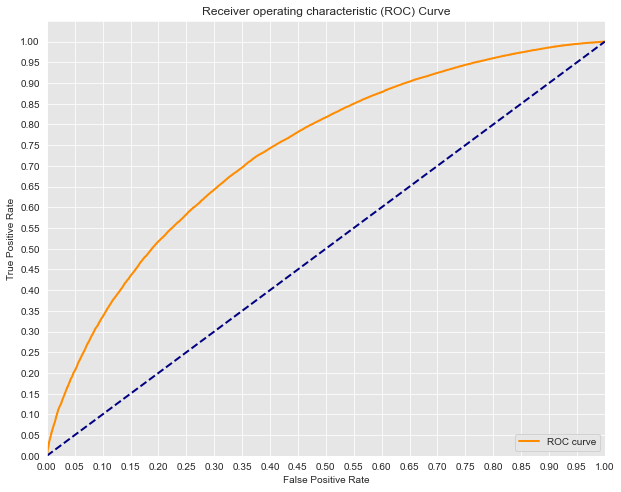

In [235]:
make_roc_curve(sc_dec_tr, y_train, model_type='logistic')

AUC: 0.7375750836830259


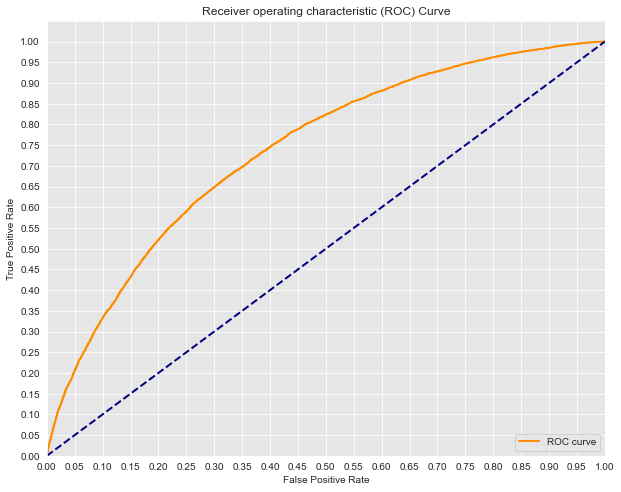

In [236]:
make_roc_curve(sc_dec_te, y_test, model_type='logistic')

In [237]:
model_sag = LogisticRegressionThreshold(random_state=42, C=100, solver='sag')
model_sag.fit(Xtr_transformed, y_train)

sag_pred_tr = model_sag.predict(Xtr_transformed)
sag_pred_te = model_sag.predict(Xte_transformed)


evaluation_metrics(sag_pred_tr, yc_train)

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[[28325 17089]
 [14076 36597]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.65     45414
           1       0.68      0.72      0.70     50673

    accuracy                           0.68     96087
   macro avg       0.67      0.67      0.67     96087
weighted avg       0.68      0.68      0.67     96087



In [238]:
evaluation_metrics(sag_pred_te, yc_test)

[[ 9491  5648]
 [ 4708 12183]]
              precision    recall  f1-score   support

           0       0.67      0.63      0.65     15139
           1       0.68      0.72      0.70     16891

    accuracy                           0.68     32030
   macro avg       0.68      0.67      0.67     32030
weighted avg       0.68      0.68      0.68     32030



In [239]:
model_lbfgs = LogisticRegressionThreshold(random_state=42, C=0.01, solver='lbfgs')
model_lbfgs.fit(Xtr_transformed, y_train)

lb_pred_tr = model_lbfgs.predict(Xtr_transformed)
lb_pred_te = model_lbfgs.predict(Xte_transformed)

evaluation_metrics(lb_pred_tr, yc_train)

[[28249 17165]
 [13943 36730]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.64     45414
           1       0.68      0.72      0.70     50673

    accuracy                           0.68     96087
   macro avg       0.68      0.67      0.67     96087
weighted avg       0.68      0.68      0.68     96087



In [240]:
evaluation_metrics(lb_pred_te, yc_test)

[[ 9445  5694]
 [ 4681 12210]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.65     15139
           1       0.68      0.72      0.70     16891

    accuracy                           0.68     32030
   macro avg       0.68      0.67      0.67     32030
weighted avg       0.68      0.68      0.68     32030



<ipython-input-139-ce7495aa9388>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x_ax=='param_vals':


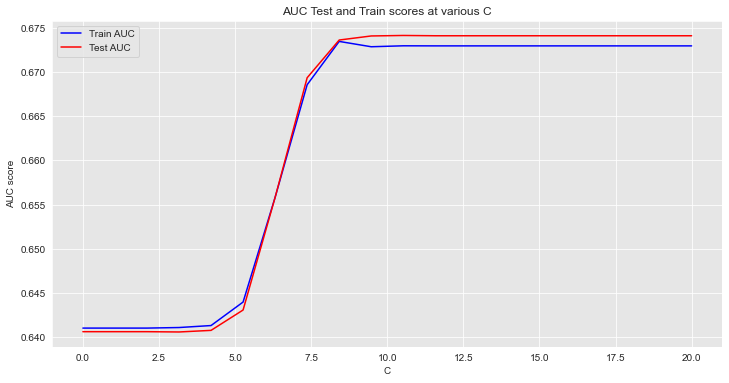

In [241]:
C_list=np.logspace(-12, 12, 20)
gr = np.linspace(0, 20, 20, endpoint=True)
test_params(C_list, Xtr_transformed, Xte_transformed, model_with_scale,'C', x_ax=gr, model_type='linear')


C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


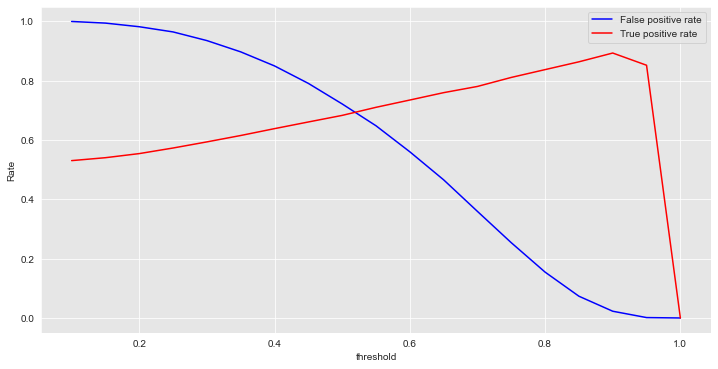

In [242]:
thresh = np.linspace(0.1, 1, 19, endpoint=True)
test_params(thresh, Xtr_transformed, Xte_transformed, model_with_scale, 'threshold', test_train='test', graph_type='tpr_v_fpr')


C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
No handles with labels found to put in legend.


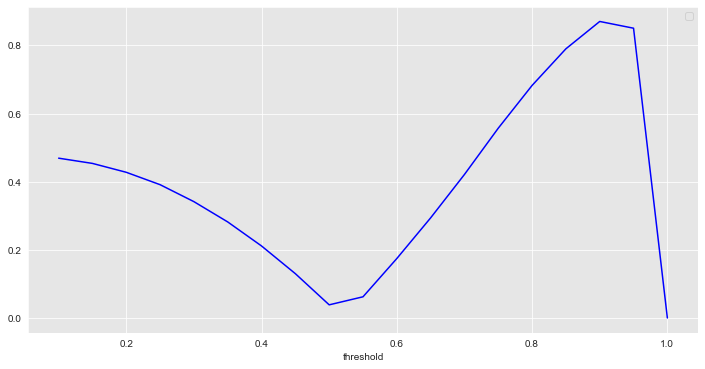

In [243]:
test_params(thresh, Xtr_transformed, Xte_transformed, model_with_scale, 'threshold', test_train='test', y_ax='diff_list', graph_type='tpr_v_fpr')
 

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
No handles with labels found to put in legend.


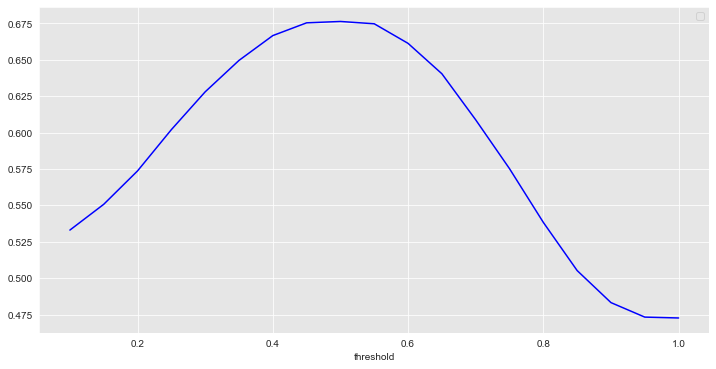

In [244]:
test_params(thresh, Xtr_transformed, Xte_transformed, model_with_scale, 'threshold', test_train='test', y_ax='acc_list', graph_type='tpr_v_fpr')

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
No handles with labels found to put in legend.


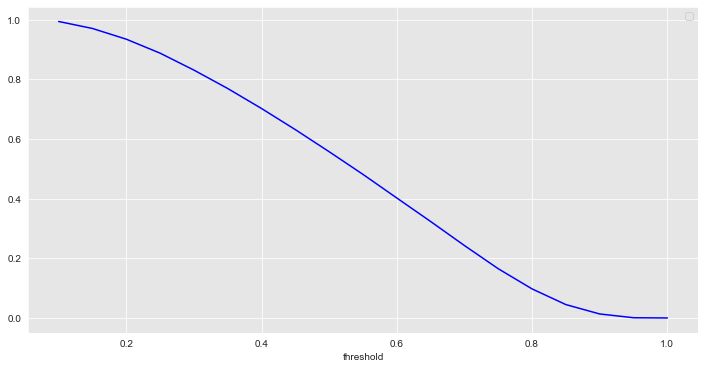

In [245]:
test_params(thresh, Xtr_transformed, Xte_transformed, model_with_scale, 'threshold', test_train='test', graph_type='tpr_v_fpr', ones=True)

In [246]:
thresh_pred = model_with_scale.predict(Xte_transformed, threshold=0.4) 
evaluation_metrics(thresh_pred, y_test)

[[ 7004  8135]
 [ 2542 14349]]
              precision    recall  f1-score   support

           0       0.73      0.46      0.57     15139
           1       0.64      0.85      0.73     16891

    accuracy                           0.67     32030
   macro avg       0.69      0.66      0.65     32030
weighted avg       0.68      0.67      0.65     32030



## sm log func

In [75]:
alpha=1/0.01

In [76]:
def sm_log(X_train, X_test):
    sm_preds=[]
    X_int = sm.add_constant(X_train)
    pred_int = sm.add_constant(X_test)

    # Fit model
    logit_model = sm.Logit(y_train, X_int)

    # Get results of the fit
    result = logit_model.fit_regularized(alpha=alpha)
    res_pred= result.predict(pred_int)
    for r in res_pred:
        if r>=0.4:
            pr=1
        else:
            pr=0
        sm_preds.append(pr)
    return result, sm_preds, 
    

In [77]:
sm_log_res = sm_log(Xtr_transformed, Xte_transformed)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6109256945437221
            Iterations: 143
            Function evaluations: 144
            Gradient evaluations: 143


In [78]:
evaluation_metrics(sm_log_res[1], y_test)

[[ 6685  8454]
 [ 2393 14498]]
              precision    recall  f1-score   support

           0       0.74      0.44      0.55     15139
           1       0.63      0.86      0.73     16891

    accuracy                           0.66     32030
   macro avg       0.68      0.65      0.64     32030
weighted avg       0.68      0.66      0.64     32030



In [79]:
p_df = pd.DataFrame(sm_log_res[0].pvalues)

In [80]:
lp_df=p_df[p_df[0]<=0.05]
hp_df=p_df[p_df[0]>0.05]

lp_df.reset_index(drop=False, inplace=True)
hp_df.reset_index(drop=False, inplace=True)

good_feat_list=lp_df['index'].tolist()
bad_feat_list=hp_df['index'].tolist()

In [81]:
good_feat_list.remove('const')

In [257]:
#good_feat_list.append('Feeling down, depressed, or hopeless')

In [82]:
X_new_train = Xtr_transformed[good_feat_list]
X_new_test = Xte_transformed[good_feat_list]

In [83]:
model_with_scale.fit(X_new_train, y_train)
new_pred_test = model_with_scale.predict(X_new_test)

In [264]:
evaluation_metrics(new_pred_test, y_test)

[[ 9454  5685]
 [ 4716 12175]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.65     15139
           1       0.68      0.72      0.70     16891

    accuracy                           0.68     32030
   macro avg       0.67      0.67      0.67     32030
weighted avg       0.67      0.68      0.67     32030



In [84]:
sm_new=sm_log(X_new_train, X_new_test)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.611002560483105
            Iterations: 110
            Function evaluations: 111
            Gradient evaluations: 110


In [270]:
evaluation_metrics(sm_new[1], y_test)

[[ 6659  8480]
 [ 2389 14502]]
              precision    recall  f1-score   support

           0       0.74      0.44      0.55     15139
           1       0.63      0.86      0.73     16891

    accuracy                           0.66     32030
   macro avg       0.68      0.65      0.64     32030
weighted avg       0.68      0.66      0.64     32030



In [85]:
new_log_df=pd.DataFrame(sm_new[0].pvalues)
new_log_df.reset_index(inplace=True)

In [272]:
sm_new[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 PHQ4_2   No. Observations:                96087
Model:                          Logit   Df Residuals:                    96047
Method:                           MLE   Df Model:                           39
Date:                Wed, 12 Jan 2022   Pseudo R-squ.:                  0.1259
Time:                        14:12:45   Log-Likelihood:                -58094.
converged:                       True   LL-Null:                       -66458.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================================================================================================================================
                                                                                                                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                                     -0.2509      0.016    -16.142      0.000      -0.281      -0.220
Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?                  -0.0405      0.007     -5.626      0.000      -0.055      -0.026
If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?     0.0843      0.008     10.377      0.000       0.068       0.100
Washed hands with soap and water                                                                                                                           0.0533      0.009      6.193      0.000       0.036       0.070
Covered your nose and mouth when sneezing or coughing                                                                                                      0.0392      0.009      4.553      0.000       0.022       0.056
Avoided contact with people who have symptoms or you think may have been exposed to the coronavirus                                                        0.0524      0.009      5.782      0.000       0.035       0.070
Avoided going out in general                                                                                                                              -0.1971      0.010    -20.361      0.000      -0.216      -0.178
Avoided going to hospital or other healthcare settings                                                                                                     0.0364      0.009      4.151      0.000       0.019       0.054
Avoided taking public transport                                                                                                                            0.0358      0.009      4.141      0.000       0.019       0.053
Avoided having guests to your home                                                                                                                        -0.0416      0.011     -3.955      0.000      -0.062      -0.021
Avoided small social gatherings (not more than 2 people)                                                                                                  -0.0301      0.011     -2.791      0.005      -0.051      -0.009
What is your age?                                                                                                                                         -0.4515      0.009   

In [317]:
log_mod=sm_new[0]
coeff_list = list(log_mod.params[1:])
feature_list = list(X_new_train.columns)
coeff_dict = dict(zip(feature_list, coeff_list))
coeff_sl = sorted(coeff_dict.items(), key=lambda x:x[1], reverse=True)


{'Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?': -0.0404958418306539,
 'If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?': 0.08425011589319881,
 'Washed hands with soap and water': 0.053321496867985575,
 'Covered your nose and mouth when sneezing or coughing': 0.03920215225743104,
 'Avoided contact with people who have symptoms or you think may have been exposed to the coronavirus': 0.052448493376221664,
 'Avoided going out in general': -0.1971161451179639,
 'Avoided going to hospital or other healthcare settings': 0.03644567330351385,
 'Avoided taking public transport': 0.03577478303444097,
 'Avoided having guests to your home': -0.04156764178308567,
 'Avoided small social gatherings (not more than 2 people)': -0.030128015919276316,
 'What is your age?': -0.451459749272491,
 'And how much confi

In [318]:
for k in coeff_sl:
    try:
        feature=code_dict[k[0]] 
    except: 
        feature=k[0]
    print(f'coeff for {feature} is {[k[1]]}')

coeff for country_italy is [0.5304626480035127]
coeff for emp_Unemployed is [0.45268959410269843]
coeff for My life has been greatly affected by coronavirus (COVID-19) is [0.36227135759143547]
coeff for Gender is [0.2968444017122877]
coeff for emp_Not working is [0.2635493594863684]
coeff for Arthritis is [0.24656444673023184]
coeff for High blood pressure is [0.17074744763022315]
coeff for emp_Full time student is [0.16713875859580932]
coeff for Asthma is [0.16611934188821473]
coeff for High cholesterol is [0.165849861244816]
coeff for country_france is [0.1238751312274186]
coeff for Chronic obstructive pulmonary disease (COPD) is [0.1235040778484618]
coeff for emp_Part time employment is [0.11897526712226689]
coeff for And how much confidence do you have in the NHS to respond to a Coronavirus (COVID-19) outbreak in the UK? is [0.09217561173353858]
coeff for Coronavirus (COVID-19) is very dangerous for me is [0.08862556317016884]
coeff for If you were advised to do so by a healthcare 

In [319]:
for nb in non_bin_list:
    if nb in feature_list:
        mean=np.mean(two_df_c[nb])
        std=np.std(two_df_c[nb])
        old_co=coeff_dict[nb]
        new_co= old_co/(mean+std)
        coeff_dict   
        coeff_dict[nb]=new_co

coeff_sl = sorted(coeff_dict.items(), key=lambda x:x[1], reverse=True)
for k in coeff_sl:
    try:
        feature=code_dict[k[0]] 
    except: 
        feature=k[0]
    print(f'coeff for {feature} is {[k[1]]}')  

coeff for country_italy is [0.5304626480035127]
coeff for emp_Unemployed is [0.45268959410269843]
coeff for Gender is [0.2968444017122877]
coeff for emp_Not working is [0.2635493594863684]
coeff for Arthritis is [0.24656444673023184]
coeff for High blood pressure is [0.17074744763022315]
coeff for emp_Full time student is [0.16713875859580932]
coeff for Asthma is [0.16611934188821473]
coeff for High cholesterol is [0.165849861244816]
coeff for country_france is [0.1238751312274186]
coeff for Chronic obstructive pulmonary disease (COPD) is [0.1235040778484618]
coeff for emp_Part time employment is [0.11897526712226689]
coeff for Heart disease is [0.07648578655893226]
coeff for country_spain is [0.07153620197661001]
coeff for Diabetes is [0.07056272305423567]
coeff for My life has been greatly affected by coronavirus (COVID-19) is [0.05751741900577322]
coeff for If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to s

In [330]:
graph_dic={k:v for k, v in coeff_sl}

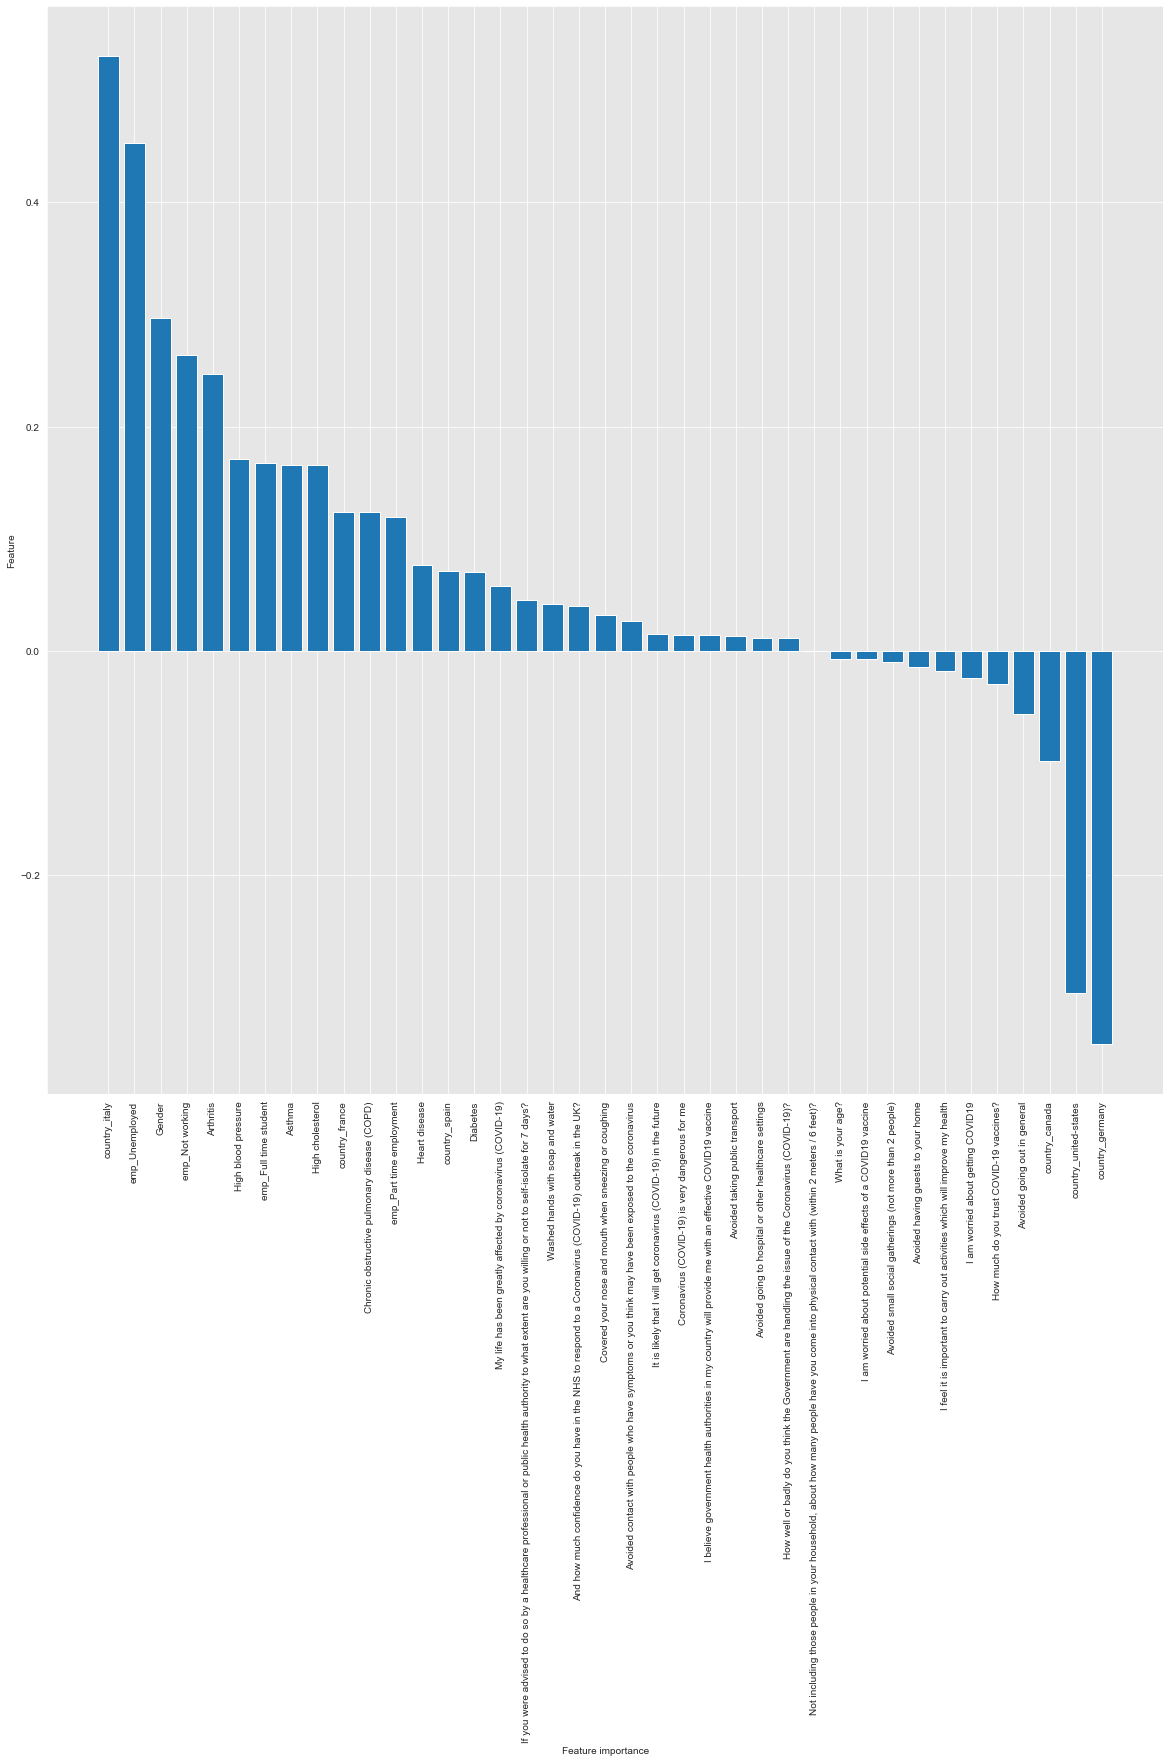

In [341]:
plt.figure(figsize=(20,20))
plt.bar(list(graph_dic.keys()), list(graph_dic.values()), align='center') 
#plt.yticks(np.arange(n_features), feat_list)
plt.xticks(rotation=90) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [349]:
for feat in graph_dic:
  #  print(f'increasing {feat} by one unit increases the odds of reporting depression by {int(10*(1-(np.exp(graph_dic[feat]))))} percent')
    print(f'increasing {feat} by one unit increases the odds of reporting depression by {int(100*(np.exp(graph_dic[feat])-1))} percent')

increasing country_italy by one unit increases the odds of reporting depression by 69 percent
increasing emp_Unemployed by one unit increases the odds of reporting depression by 57 percent
increasing Gender by one unit increases the odds of reporting depression by 34 percent
increasing emp_Not working by one unit increases the odds of reporting depression by 30 percent
increasing Arthritis by one unit increases the odds of reporting depression by 27 percent
increasing High blood pressure by one unit increases the odds of reporting depression by 18 percent
increasing emp_Full time student by one unit increases the odds of reporting depression by 18 percent
increasing Asthma by one unit increases the odds of reporting depression by 18 percent
increasing High cholesterol by one unit increases the odds of reporting depression by 18 percent
increasing country_france by one unit increases the odds of reporting depression by 13 percent
increasing Chronic obstructive pulmonary disease (COPD) b

In [92]:
masker_log = shap.maskers.Independent(data = X_new_train)

explainer_log = shap.LinearExplainer(model_with_scale, masker = masker_log)
shap_val = explainer_log(X_new_test)

 38%|███▊      | 15/39 [00:19<01:34,  3.93s/it]


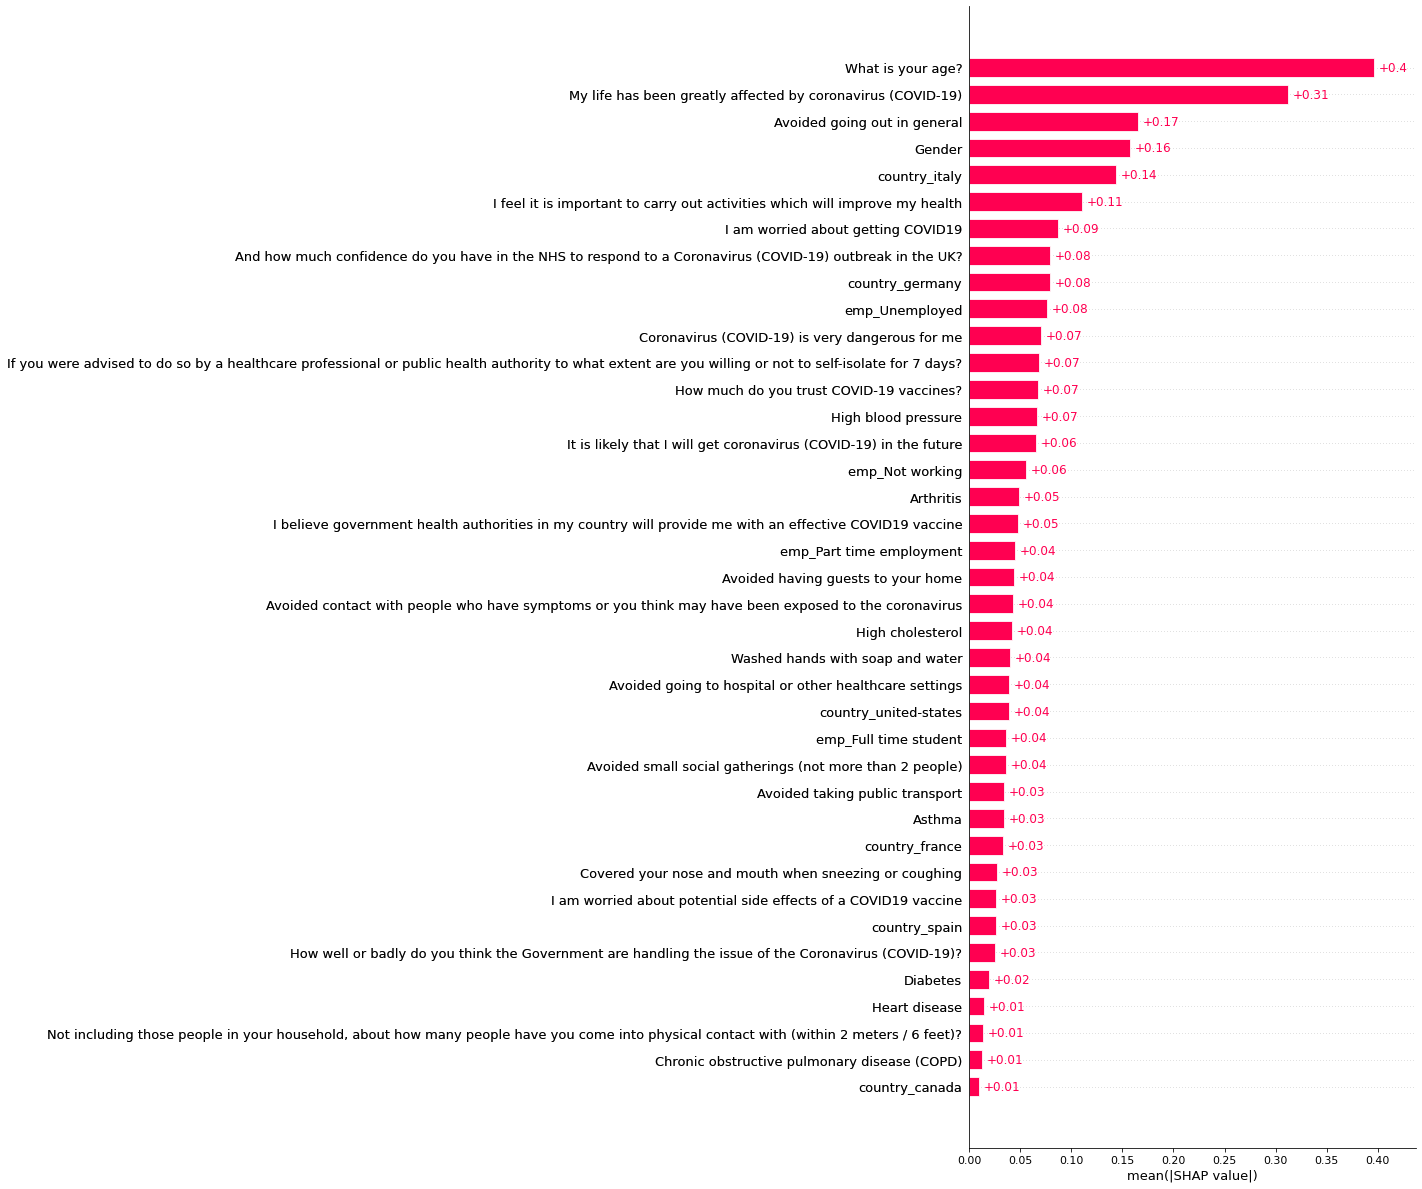

In [103]:
shap.plots.bar(shap_val, max_display=400)

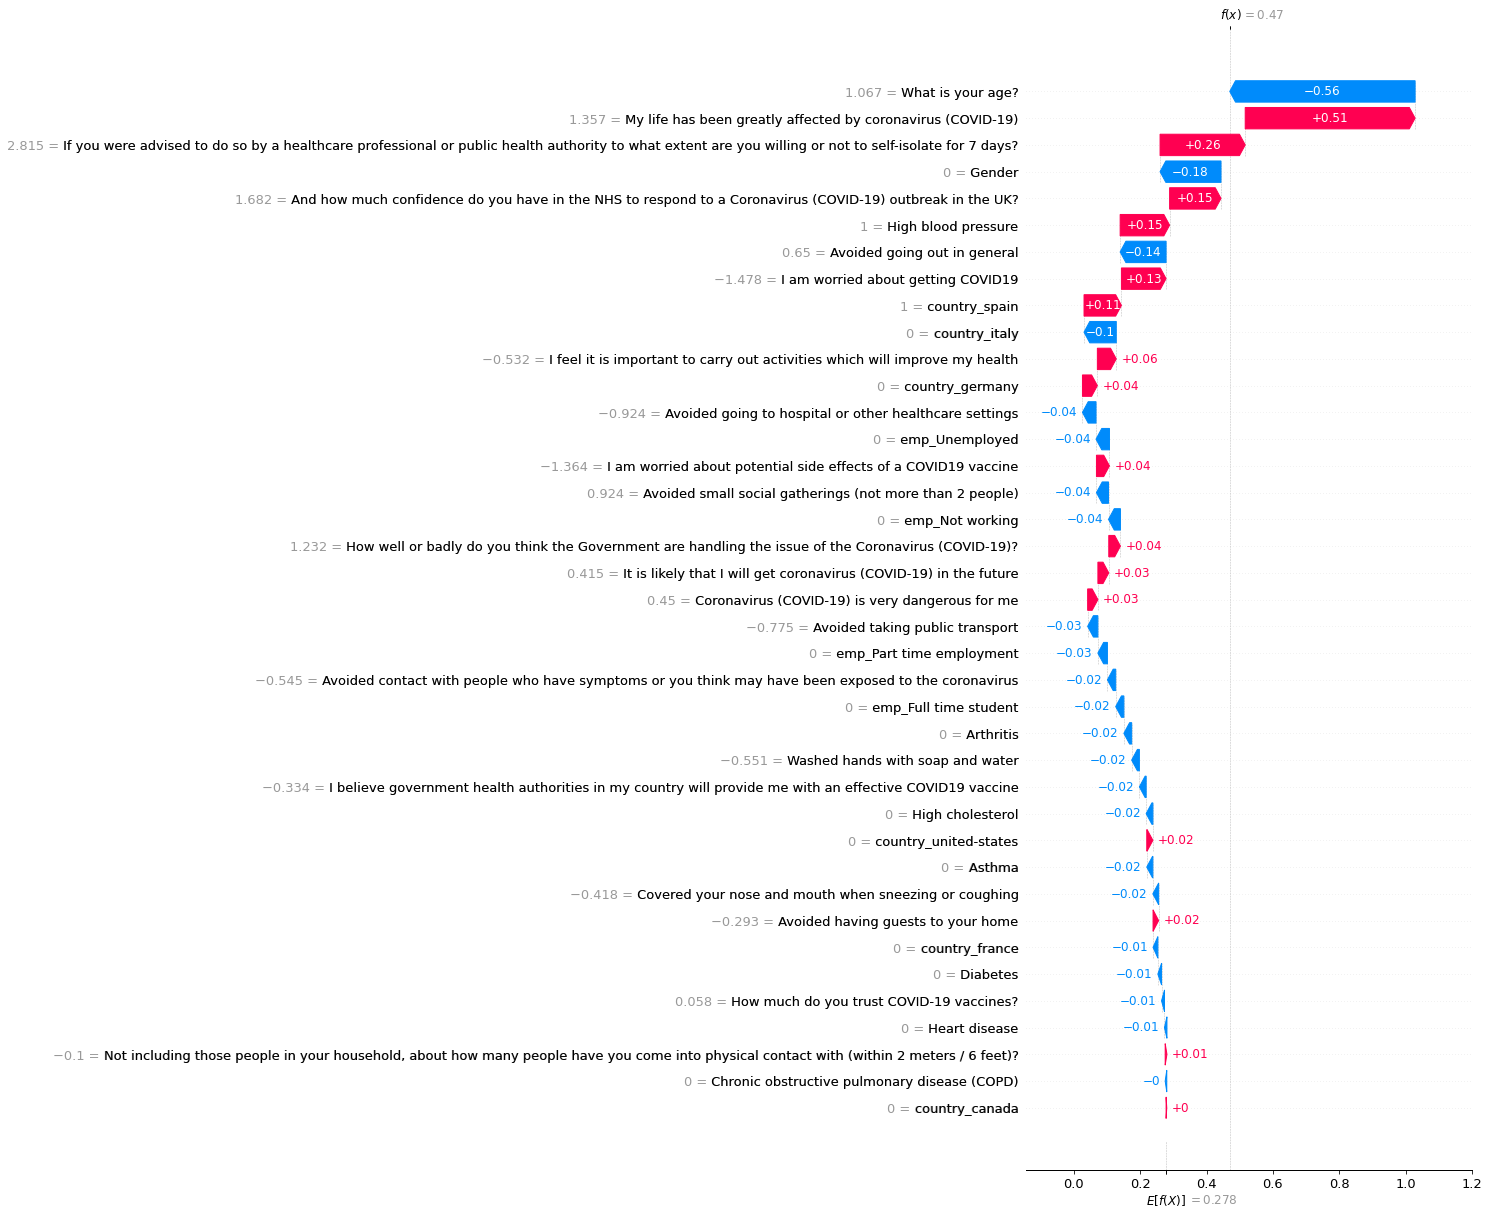

In [99]:
sample_ind = 25
shap.plots.waterfall(shap_val[sample_ind], max_display=400)

# decision tree

In [26]:
clf_base = DecisionTreeClassifier(criterion='entropy')

clf_base.fit(Xc_train, yc_train)



DecisionTreeClassifier(criterion='entropy')

In [27]:
clf_pred_train = clf_base.predict(Xc_train)
evaluation_metrics(clf_pred_train, y_train)

[[45414     0]
 [    0 50673]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45414
           1       1.00      1.00      1.00     50673

    accuracy                           1.00     96087
   macro avg       1.00      1.00      1.00     96087
weighted avg       1.00      1.00      1.00     96087



In [28]:
clf_pred_test = clf_base.predict(Xc_test)
evaluation_metrics(clf_pred_test, y_test)

[[ 8795  6344]
 [ 6531 10360]]
              precision    recall  f1-score   support

           0       0.57      0.58      0.58     15139
           1       0.62      0.61      0.62     16891

    accuracy                           0.60     32030
   macro avg       0.60      0.60      0.60     32030
weighted avg       0.60      0.60      0.60     32030



coeff for It is likely that I will get coronavirus (COVID-19) in the future is [0.0673172960035174]
coeff for country_italy is [0.02915309292930021]
coeff for emp_Part time employment is [0.028612070717333883]
coeff for I am worried about getting COVID19 is [0.02200514946719801]
coeff for Diabetes is [0.019999999999999997]
coeff for I feel it is important to carry out activities which will improve my health is [0.019077563954531467]
coeff for Arthritis is [0.01654367840326094]
coeff for A vaccine for coronavirus (COVID-19) will protect me against any variants, strains or mutations of coronavirus is [0.011338701694538073]
coeff for Avoided small social gatherings (not more than 2 people) is [0.010676384094105618]
coeff for Getting a vaccine will protect others against coronavirus (COVID-19) is [0.006935763514710885]
coeff for I believe government health authorities in my country will provide me with an effective COVID19 vaccine is [0.006392354868940758]
coeff for Number of people in hou

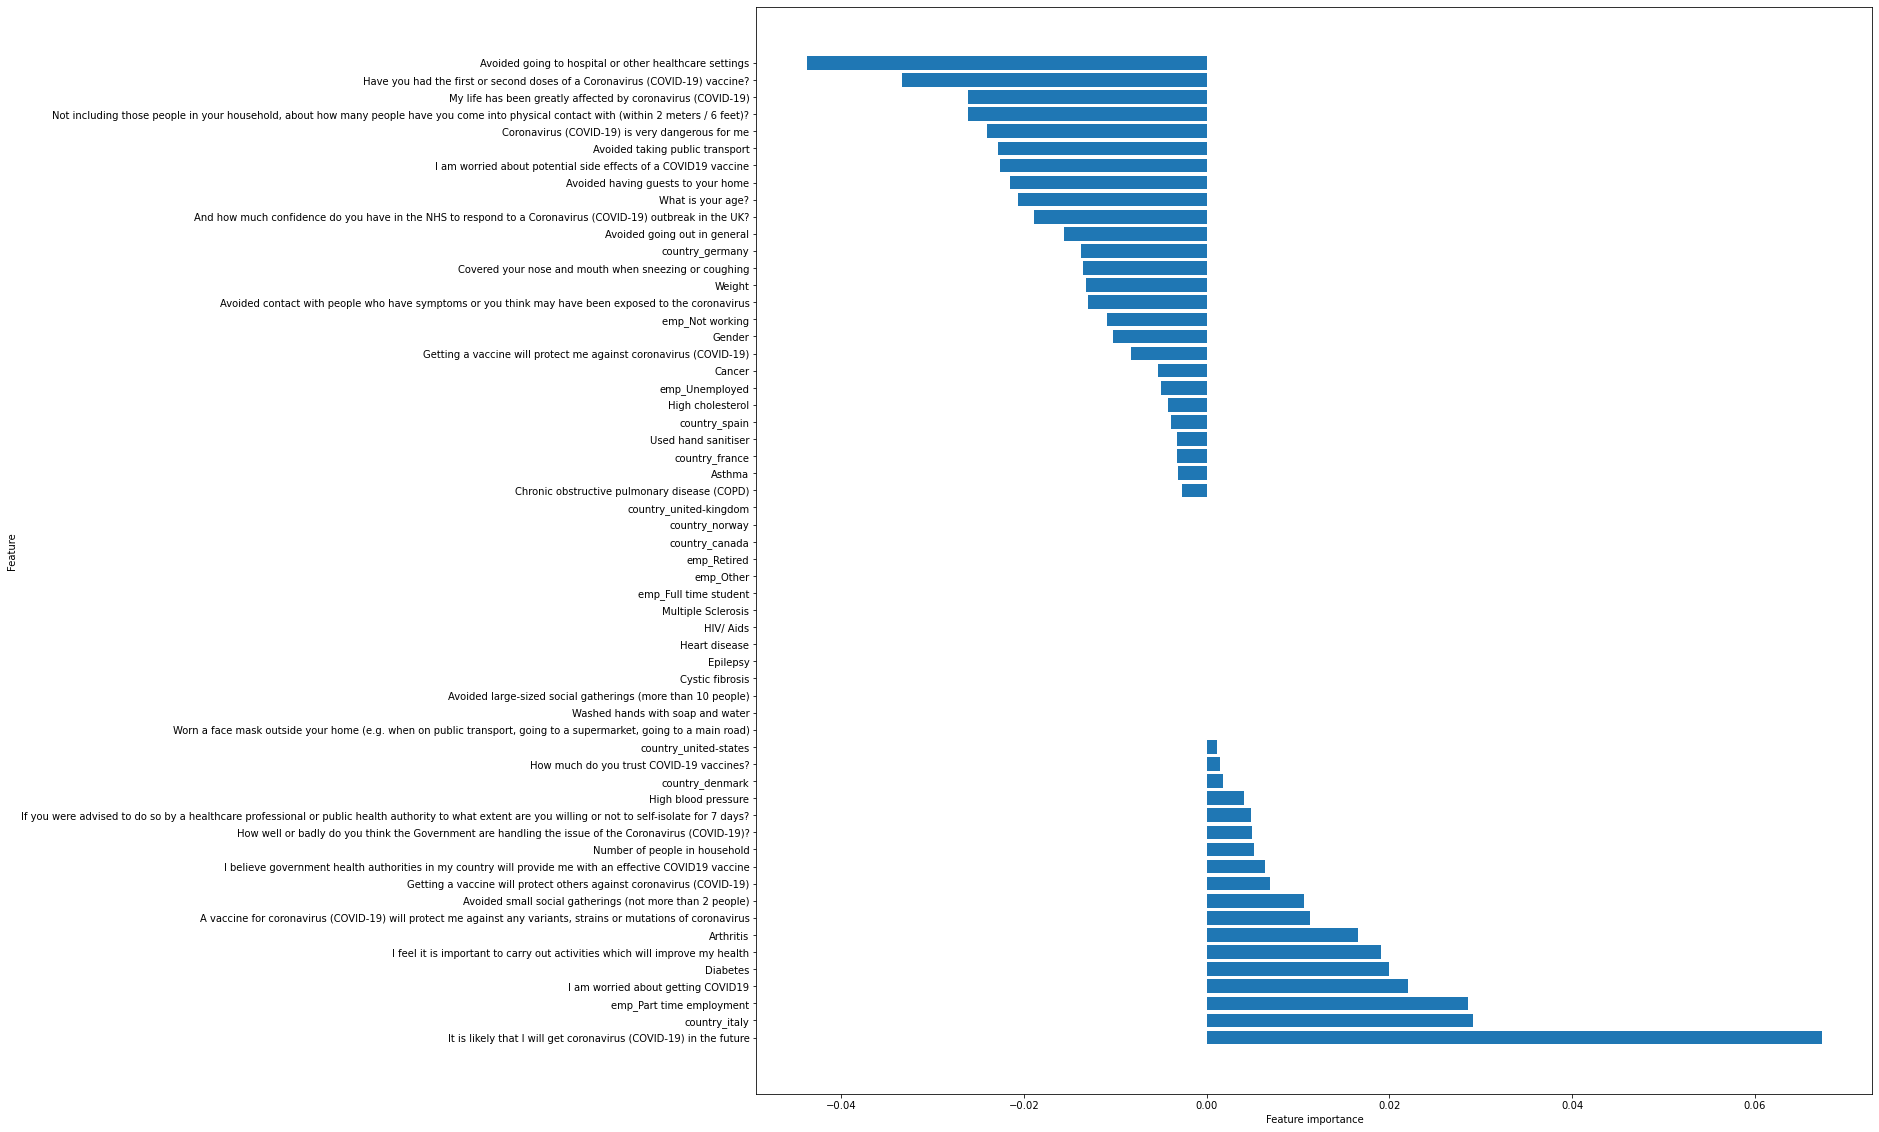

[('r1_2', 0.0673172960035174),
 ('country_italy', 0.02915309292930021),
 ('emp_Part time employment', 0.028612070717333883),
 ('vac2_1', 0.02200514946719801),
 ('d1_health_6', 0.019999999999999997),
 ('r1_6', 0.019077563954531467),
 ('d1_health_1', 0.01654367840326094),
 ('vac2_7', 0.011338701694538073),
 ('i12_health_12', 0.010676384094105618),
 ('r1_9', 0.006935763514710885),
 ('vac2_3', 0.006392354868940758),
 ('household_size', 0.005202935769934336),
 ('WCRex1', 0.004957408183214634),
 ('i11_health', 0.004843856849783451),
 ('d1_health_9', 0.004098159642293281),
 ('country_denmark', 0.0018355293048614274),
 ('vac7', 0.0014507499758123765),
 ('country_united-states', 0.0011531358319712027),
 ('i12_health_1', 0.0),
 ('i12_health_2', 0.0),
 ('i12_health_14', 0.0),
 ('d1_health_4', 0.0),
 ('d1_health_7', 0.0),
 ('d1_health_8', 0.0),
 ('d1_health_11', 0.0),
 ('d1_health_13', 0.0),
 ('emp_Full time student', 0.0),
 ('emp_Other', 0.0),
 ('emp_Retired', 0.0),
 ('country_canada', 0.0),
 ('c

In [42]:
prediction_t, bias_t, contributions_t = ti.predict(clf_base, Xc_test)
important_cols(contributions_t)

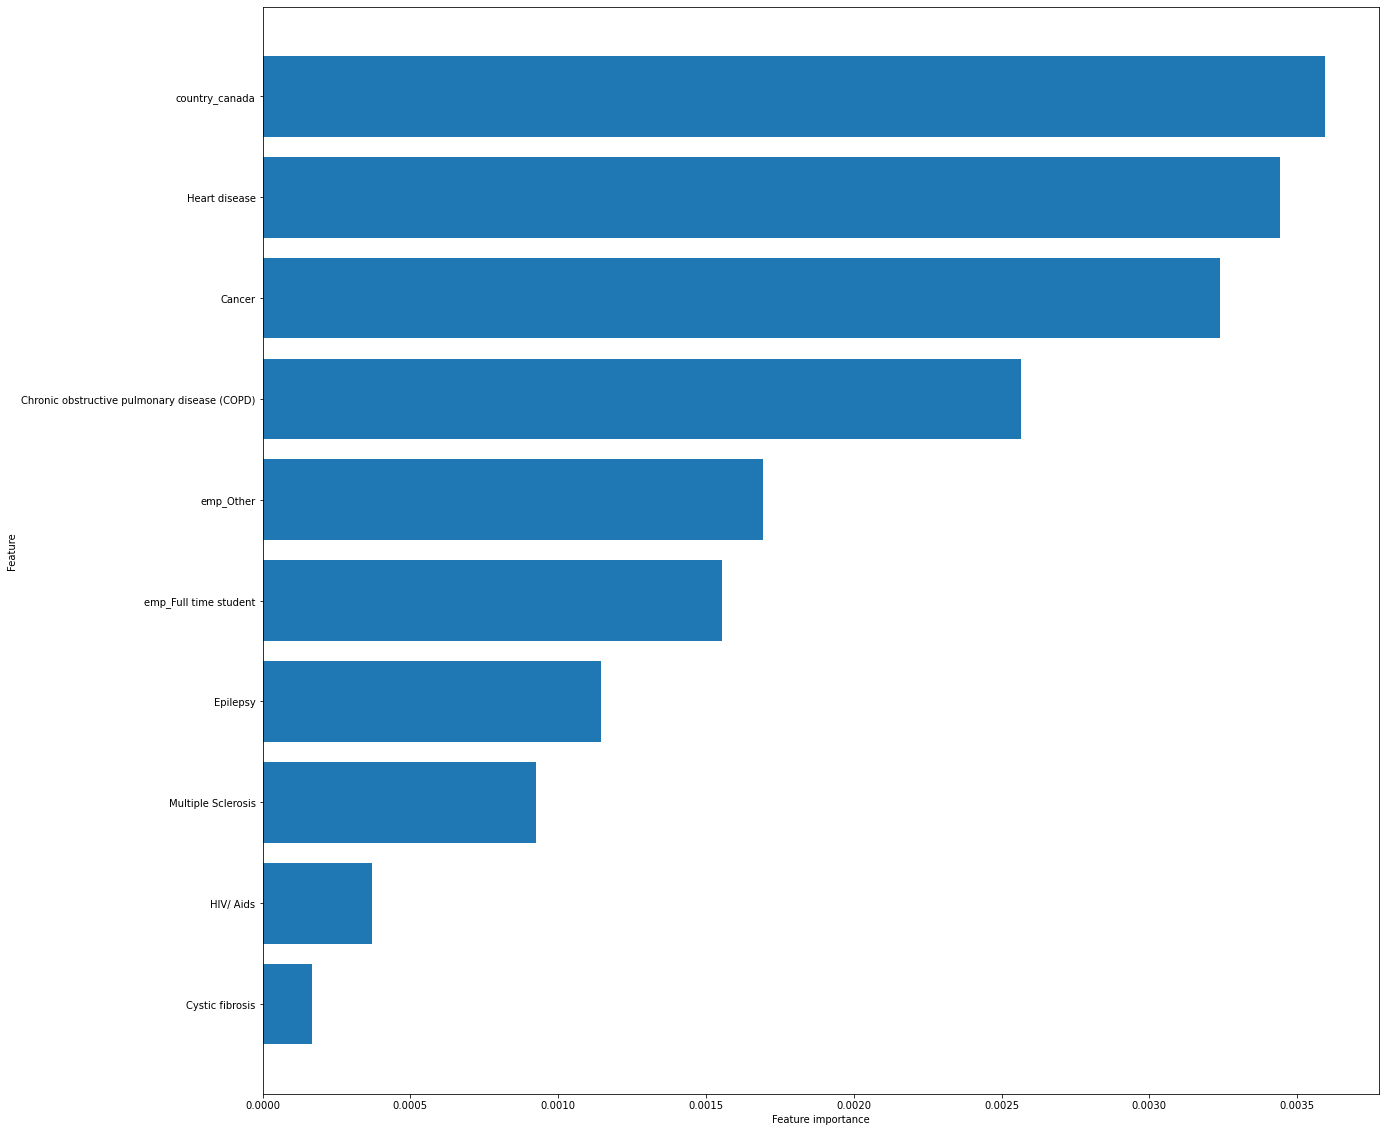

In [147]:
plot_feature_importances(clf_base, Xc_train, feat_lim=10)

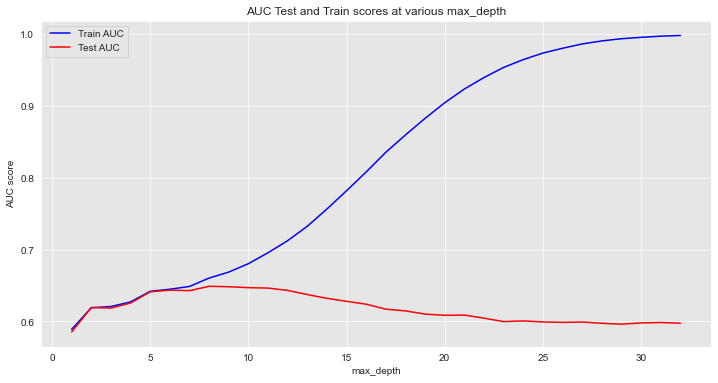

In [357]:
clf_depth_test = clone(clf_base)
clf_depth_test.fit(X_train, y_train)

test_params(max_depths, Xc_train, Xc_test, clf_depth_test, 'max_depth', model_type='tree')


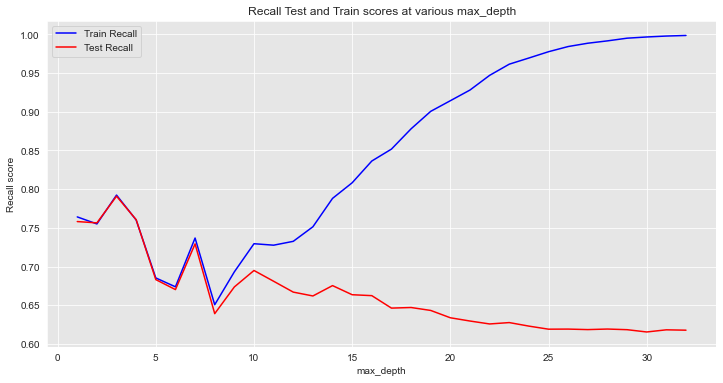

In [360]:
test_params(max_depths, Xc_train, Xc_test, clf_depth_test, 'max_depth', model_type='tree', rec='yes')

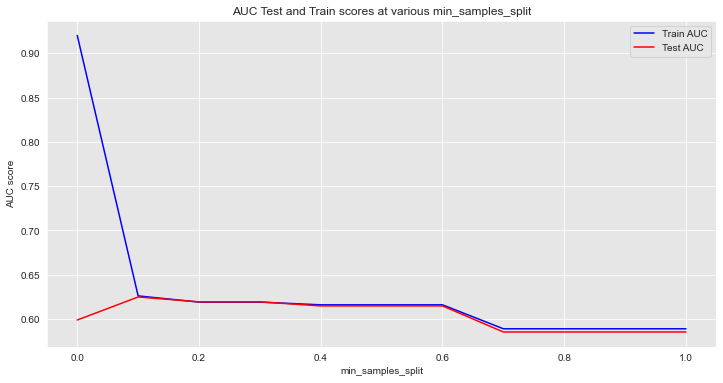

In [361]:
clf_min_samp_test = clone(clf_base)

test_params(min_samples_splits, Xc_train, Xc_test, clf_min_samp_test, 'min_samples_split', model_type='tree')

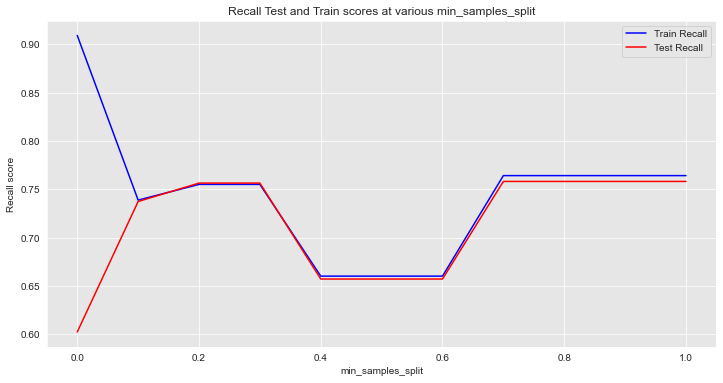

In [362]:
test_params(min_samples_splits, Xc_train, Xc_test, clf_min_samp_test, 'min_samples_split', model_type='tree', rec='yes')

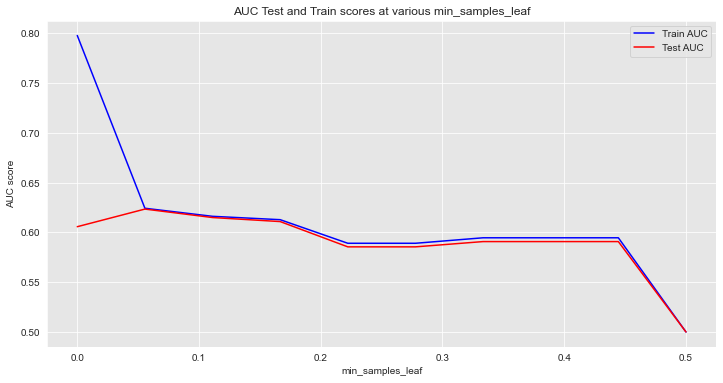

In [363]:
clf_min_samp_leaf_test = clone(clf_base)

test_params(min_samples_leafs, Xc_train, Xc_test, clf_min_samp_leaf_test, 'min_samples_leaf', model_type='tree')


No handles with labels found to put in legend.


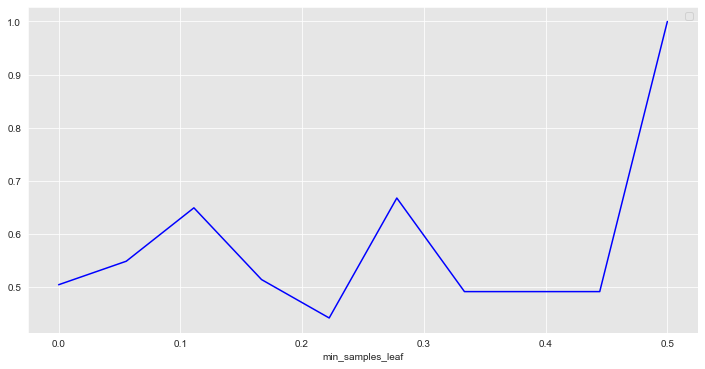

In [364]:
test_params(min_samples_leafs, Xc_train, Xc_test, clf_min_samp_leaf_test, 'min_samples_leaf', 
            model_type='tree', ones='yes', graph_type= 'tpr_v_fpr')

No handles with labels found to put in legend.


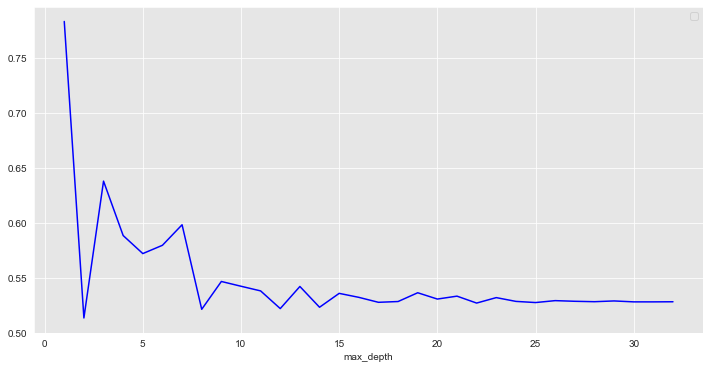

In [365]:
test_params(max_depths, Xc_train, Xc_test, clf_depth_test, 'max_depth', model_type='tree', ones='yes', graph_type= 'tpr_v_fpr')

No handles with labels found to put in legend.


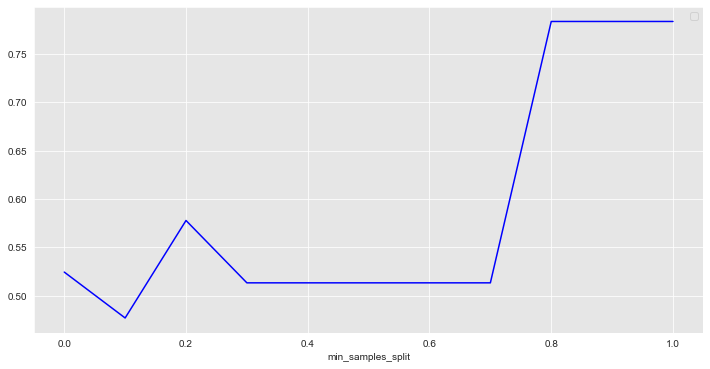

In [367]:
test_params(min_samples_splits, Xc_train, Xc_test, clf_min_samp_test, 'min_samples_split', model_type='tree', ones='yes', graph_type= 'tpr_v_fpr')

In [31]:
param_grid_tr = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [0.1, 0.2, 0.3],
    'min_samples_leaf': [1, 2, 3],
}

In [32]:
grid_tree = GridSearchCV(clf_base, param_grid_tr, scoring='accuracy', cv=None, n_jobs=1)
grid_tree.fit(Xc_train, y_train)

best_parameters = grid_tree.best_params_

In [33]:
best_parameters 

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 0.1}

In [34]:
clf_tuned=DecisionTreeClassifier(criterion='entropy', max_depth =10, min_samples_split=0.1, 
                                 min_samples_leaf = 1)


In [43]:
clf_tuned.fit(Xc_train, y_train)

clftun_pred_train = clf_tuned.predict(Xc_train)
evaluation_metrics(clftun_pred_train, y_train)

[[23319 22095]
 [13233 37440]]
              precision    recall  f1-score   support

           0       0.64      0.51      0.57     45414
           1       0.63      0.74      0.68     50673

    accuracy                           0.63     96087
   macro avg       0.63      0.63      0.62     96087
weighted avg       0.63      0.63      0.63     96087



In [44]:
clftun_pred_test = clf_tuned.predict(X_test)
evaluation_metrics(clftun_pred_test, y_test)

[[ 7759  7380]
 [ 4436 12455]]
              precision    recall  f1-score   support

           0       0.64      0.51      0.57     15139
           1       0.63      0.74      0.68     16891

    accuracy                           0.63     32030
   macro avg       0.63      0.62      0.62     32030
weighted avg       0.63      0.63      0.63     32030



In [45]:
predictiont1, biast1, contributionst1 = ti.predict(clf_tuned, Xc_test)

coeff for What is your age? is [0.023735374303614488]
coeff for And how much confidence do you have in the NHS to respond to a Coronavirus (COVID-19) outbreak in the UK? is [0.005948202739717312]
coeff for Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)? is [0.0]
coeff for If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days? is [0.0]
coeff for Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road) is [0.0]
coeff for Washed hands with soap and water is [0.0]
coeff for Used hand sanitiser is [0.0]
coeff for Covered your nose and mouth when sneezing or coughing is [0.0]
coeff for Avoided contact with people who have symptoms or you think may have been exposed to the coronavirus is [0.0]
coeff for Avoided going to hospital or other healthcare setting

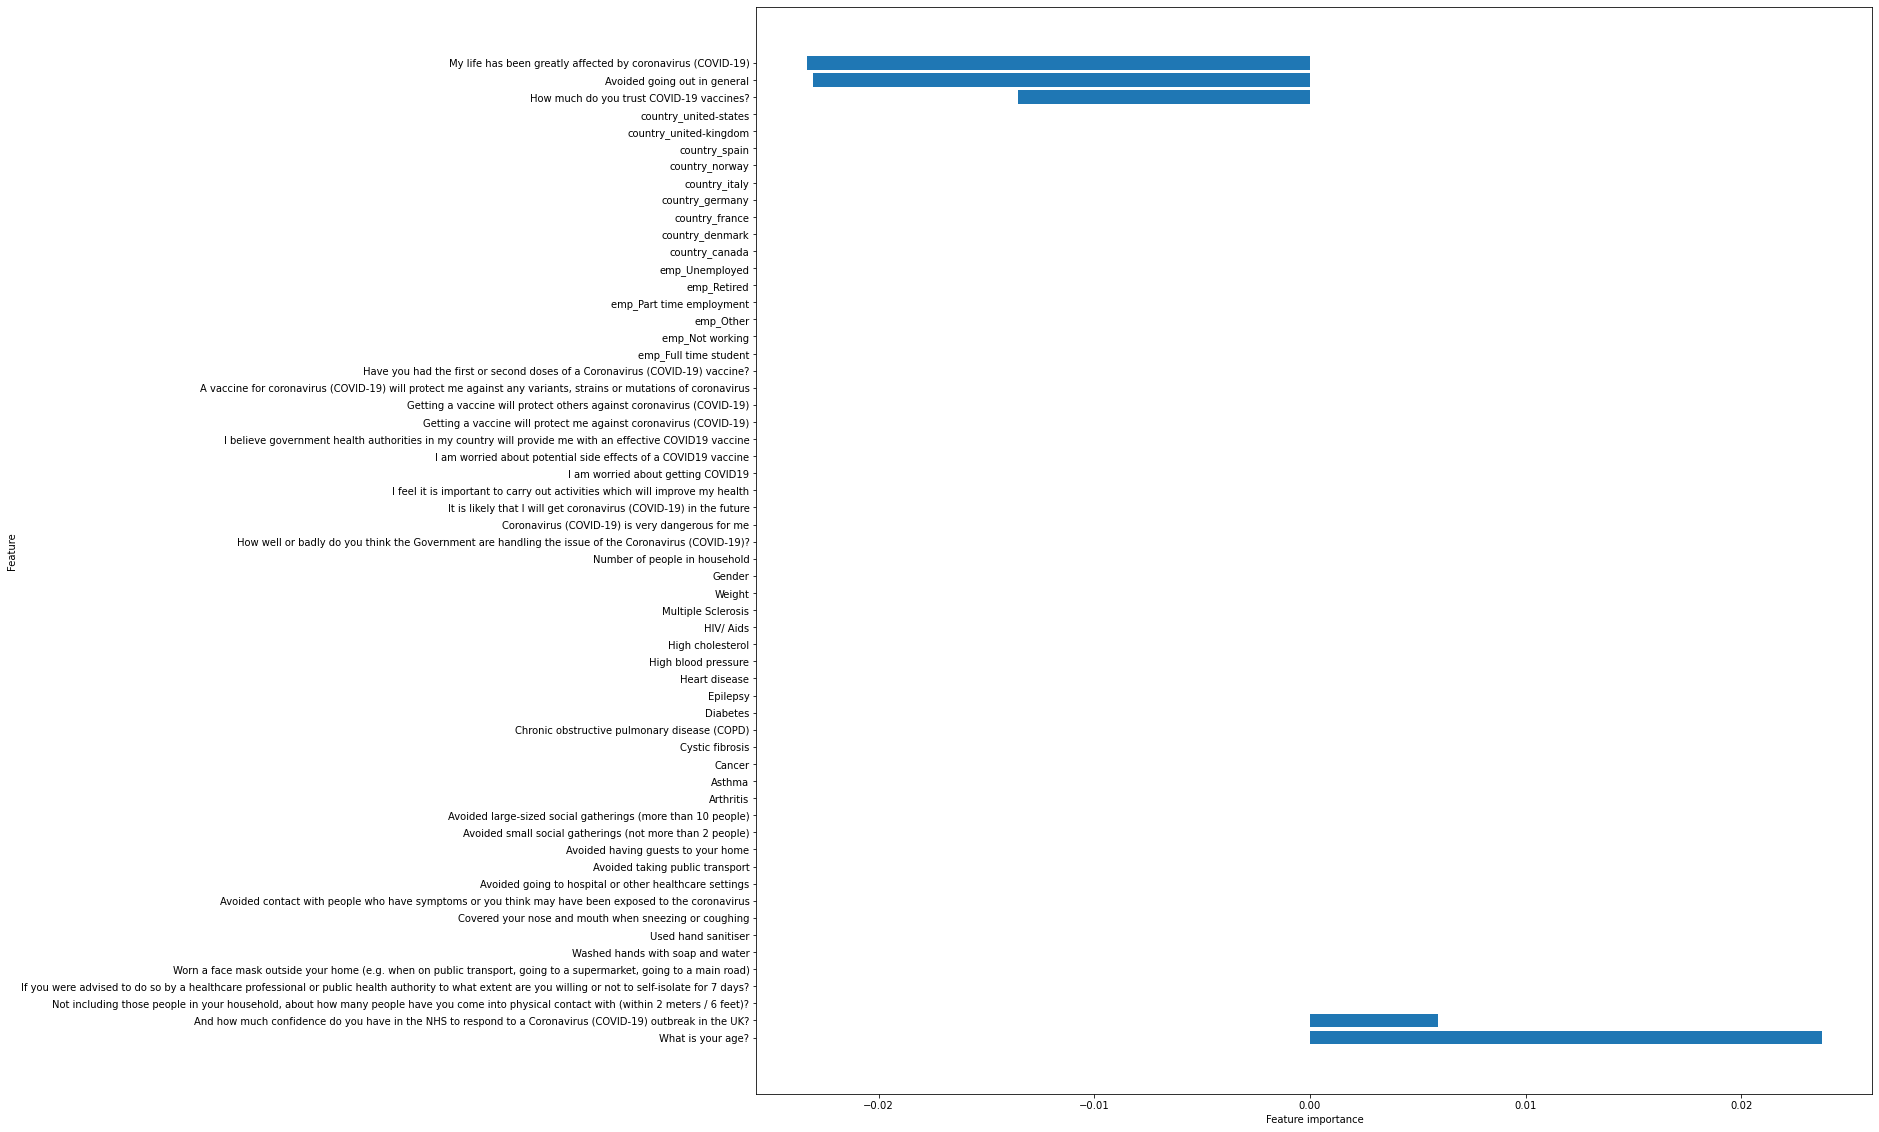

[('age', 0.023735374303614488),
 ('WCRex2', 0.005948202739717312),
 ('i2_health', 0.0),
 ('i11_health', 0.0),
 ('i12_health_1', 0.0),
 ('i12_health_2', 0.0),
 ('i12_health_3', 0.0),
 ('i12_health_4', 0.0),
 ('i12_health_5', 0.0),
 ('i12_health_7', 0.0),
 ('i12_health_8', 0.0),
 ('i12_health_11', 0.0),
 ('i12_health_12', 0.0),
 ('i12_health_14', 0.0),
 ('d1_health_1', 0.0),
 ('d1_health_2', 0.0),
 ('d1_health_3', 0.0),
 ('d1_health_4', 0.0),
 ('d1_health_5', 0.0),
 ('d1_health_6', 0.0),
 ('d1_health_7', 0.0),
 ('d1_health_8', 0.0),
 ('d1_health_9', 0.0),
 ('d1_health_10', 0.0),
 ('d1_health_11', 0.0),
 ('d1_health_13', 0.0),
 ('weight', 0.0),
 ('gender', 0.0),
 ('household_size', 0.0),
 ('WCRex1', 0.0),
 ('r1_1', 0.0),
 ('r1_2', 0.0),
 ('r1_6', 0.0),
 ('vac2_1', 0.0),
 ('vac2_2', 0.0),
 ('vac2_3', 0.0),
 ('r1_8', 0.0),
 ('r1_9', 0.0),
 ('vac2_7', 0.0),
 ('vac', 0.0),
 ('emp_Full time student', 0.0),
 ('emp_Not working', 0.0),
 ('emp_Other', 0.0),
 ('emp_Part time employment', 0.0),
 ('e

In [47]:
important_cols(contributionst1)

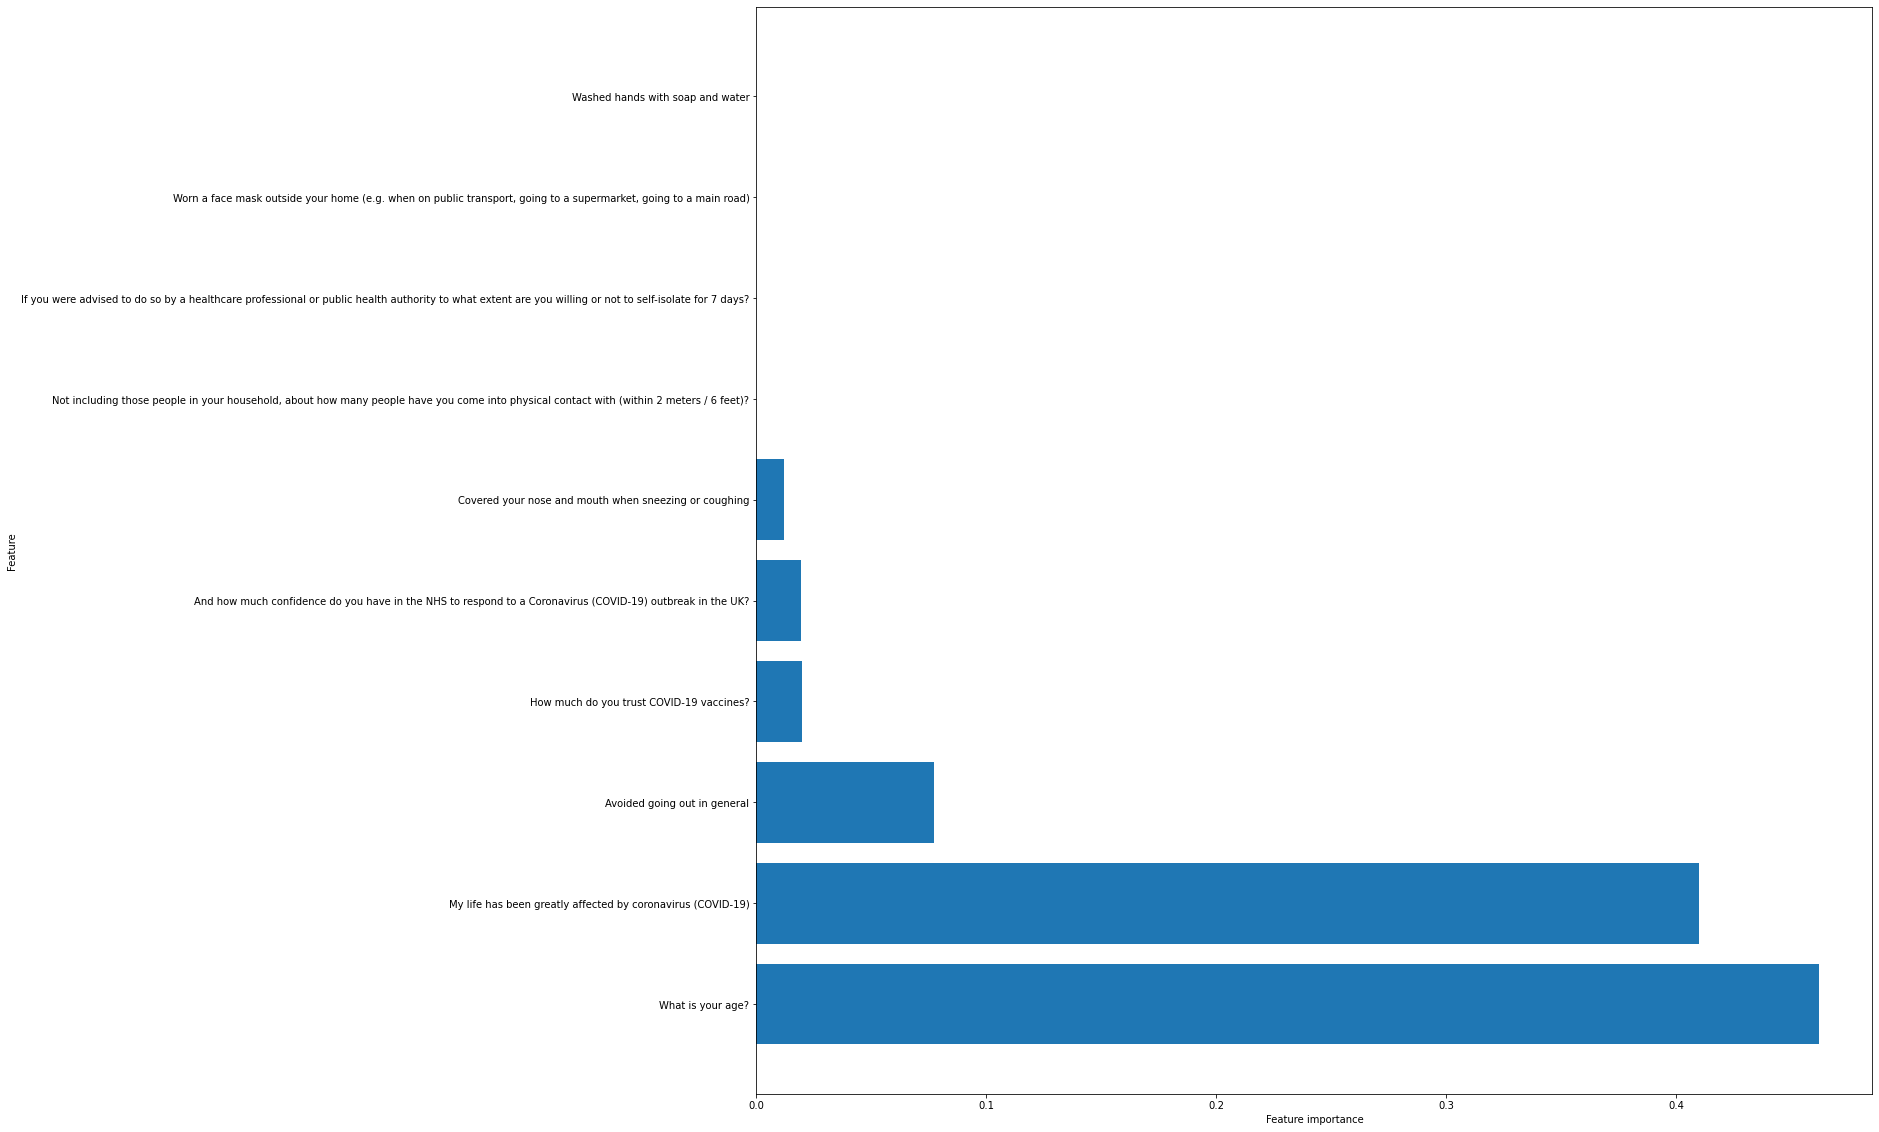

In [153]:
plot_feature_importances(clf_tuned, Xc_train, feat_lim=10)

# Random forest

## bag

In [190]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [191]:
bagged_tree.fit(Xc_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

In [192]:
bt_pred_test = bagged_tree.predict(Xc_test)
evaluation_metrics(bt_pred_test, y_test)

[[ 8537  6602]
 [ 4590 12301]]
              precision    recall  f1-score   support

           0       0.65      0.56      0.60     15139
           1       0.65      0.73      0.69     16891

    accuracy                           0.65     32030
   macro avg       0.65      0.65      0.65     32030
weighted avg       0.65      0.65      0.65     32030



In [193]:
bt_pred_train = bagged_tree.predict(Xc_train)
evaluation_metrics(bt_pred_train, y_train)

[[25688 19726]
 [13580 37093]]
              precision    recall  f1-score   support

           0       0.65      0.57      0.61     45414
           1       0.65      0.73      0.69     50673

    accuracy                           0.65     96087
   macro avg       0.65      0.65      0.65     96087
weighted avg       0.65      0.65      0.65     96087



In [195]:
param_grid_bag = {
    'max_features': [0.2, 0.4, 0.6, 1.0],
    'max_samples': [0.2, 0.4, 0.6, 1.0],
    'n_estimators': [10, 50, 70],
}

In [196]:
grid_bag = GridSearchCV(bagged_tree, param_grid_bag, scoring='accuracy', cv=None, n_jobs=1)
grid_bag.fit(Xc_train, y_train)

best_parameters_tree = grid_bag.best_params_

In [197]:
best_parameters_tree

{'max_features': 0.6, 'max_samples': 6, 'n_estimators': 70}

In [216]:
tuned_bagged = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=10),
                                 max_features= 0.6, max_samples= 0.6, n_estimators= 70)

In [217]:
tuned_bagged.fit(Xc_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_features=0.6, max_samples=0.6, n_estimators=70)

In [218]:
tb_pred_test = tuned_bagged.predict(Xc_test)
evaluation_metrics(tb_pred_test, y_test)

[[ 9059  6080]
 [ 4227 12664]]
              precision    recall  f1-score   support

           0       0.68      0.60      0.64     15139
           1       0.68      0.75      0.71     16891

    accuracy                           0.68     32030
   macro avg       0.68      0.67      0.67     32030
weighted avg       0.68      0.68      0.68     32030



In [219]:
tb_pred_train = tuned_bagged.predict(Xc_train)
evaluation_metrics(tb_pred_train, y_train)

[[29210 16204]
 [10491 40182]]
              precision    recall  f1-score   support

           0       0.74      0.64      0.69     45414
           1       0.71      0.79      0.75     50673

    accuracy                           0.72     96087
   macro avg       0.72      0.72      0.72     96087
weighted avg       0.72      0.72      0.72     96087



## forest

In [258]:
class RandomForestClassifierThreshold(RandomForestClassifier):
    def predict(self, X, threshold=None):
        if threshold == None: 
            return RandomForestClassifier.predict(self, X)
        else:
            y_scores = RandomForestClassifier.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold

In [225]:
forest = RandomForestClassifier()
forest.fit(Xc_train, y_train)

RandomForestClassifier()

In [226]:
forest_pred_train = forest.predict(Xc_train)
evaluation_metrics(forest_pred_train, y_train)

[[45414     0]
 [    0 50673]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45414
           1       1.00      1.00      1.00     50673

    accuracy                           1.00     96087
   macro avg       1.00      1.00      1.00     96087
weighted avg       1.00      1.00      1.00     96087



In [227]:
forest_pred_test = forest.predict(Xc_test)
evaluation_metrics(forest_pred_test, y_test)

[[ 9768  5371]
 [ 4597 12294]]
              precision    recall  f1-score   support

           0       0.68      0.65      0.66     15139
           1       0.70      0.73      0.71     16891

    accuracy                           0.69     32030
   macro avg       0.69      0.69      0.69     32030
weighted avg       0.69      0.69      0.69     32030



In [238]:
param_grid_for = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [0.3, 0.6],
    'n_estimators': [20, 50, 100],
}

In [239]:
make_grid(forest, param_grid_for, Xc_train, y_train, Xc_test, y_test)

Grid Search found the following optimal parameters: 
max_depth: 10
min_samples_split: 0.3
n_estimators: 100

Training Accuracy: 64.39%
Validation accuracy: 64.51%


In [259]:
forest_tuned = RandomForestClassifierThreshold(max_depth=10, min_samples_split= 0.3, n_estimators= 100)
forest_tuned.fit(Xc_train, y_train)

RandomForestClassifierThreshold(max_depth=10, min_samples_split=0.3)

In [260]:
forest_tun_pred_train = forest_tuned.predict(Xc_train)
evaluation_metrics(forest_tun_pred_train, y_train)

[[21870 23544]
 [11116 39557]]
              precision    recall  f1-score   support

           0       0.66      0.48      0.56     45414
           1       0.63      0.78      0.70     50673

    accuracy                           0.64     96087
   macro avg       0.64      0.63      0.63     96087
weighted avg       0.64      0.64      0.63     96087



In [261]:
forest_tun_pred_test = forest_tuned.predict(Xc_test)
evaluation_metrics(forest_tun_pred_test, y_test)

[[ 7279  7860]
 [ 3683 13208]]
              precision    recall  f1-score   support

           0       0.66      0.48      0.56     15139
           1       0.63      0.78      0.70     16891

    accuracy                           0.64     32030
   macro avg       0.65      0.63      0.63     32030
weighted avg       0.64      0.64      0.63     32030



Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


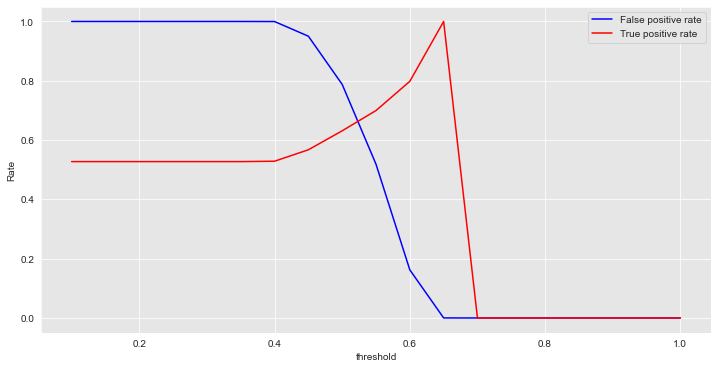

In [262]:
thresh = np.linspace(0.1, 1, 19, endpoint=True)
test_params(thresh, Xc_train, Xc_test, forest_tuned, 'threshold', test_train='test', graph_type='tpr_v_fpr')


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
No handles with labels found to put in legend.


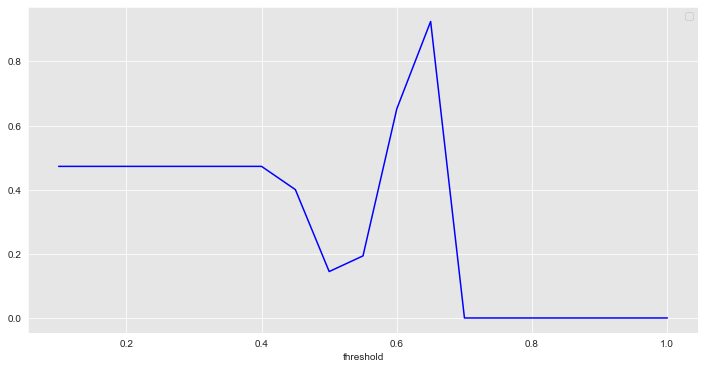

In [264]:
test_params(thresh, Xc_train, Xc_test, forest_tuned, 'threshold', test_train='test', y_ax='diff_list', graph_type='tpr_v_fpr')
 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
No handles with labels found to put in legend.


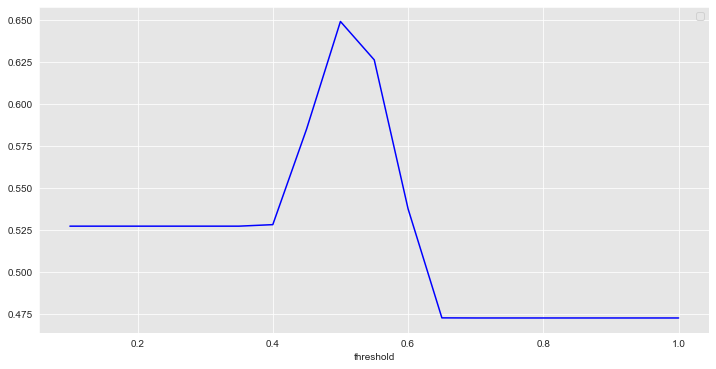

In [265]:
test_params(thresh, Xc_train, Xc_test, forest_tuned, 'threshold', test_train='test', y_ax='acc_list', graph_type='tpr_v_fpr')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

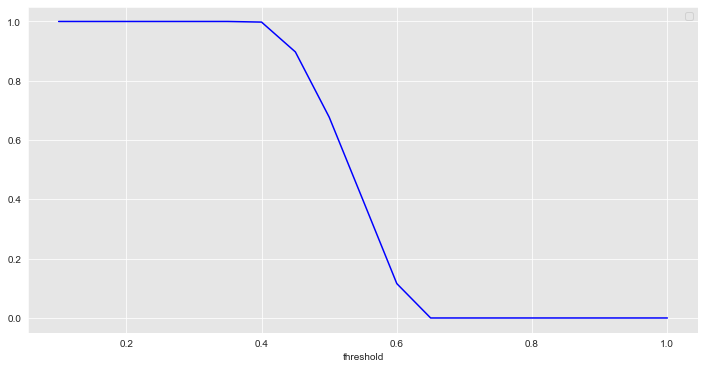

In [266]:
test_params(thresh, Xc_train, Xc_test, forest_tuned, 'threshold', test_train='test', graph_type='tpr_v_fpr', ones=True)

In [275]:
forest_tun_pred_test = forest_tuned.predict(Xc_test, threshold=0.48)
evaluation_metrics(forest_tun_pred_test, y_test)

[[ 5533  9606]
 [ 2092 14799]]
              precision    recall  f1-score   support

           0       0.73      0.37      0.49     15139
           1       0.61      0.88      0.72     16891

    accuracy                           0.63     32030
   macro avg       0.67      0.62      0.60     32030
weighted avg       0.66      0.63      0.61     32030



In [251]:
yc_train_score = forest_tuned.predict_proba(X_train)[:, 1]

yc_test_score = forest_tuned.predict_proba(X_test)[:, 1]


AUC: 0.6947430225792705


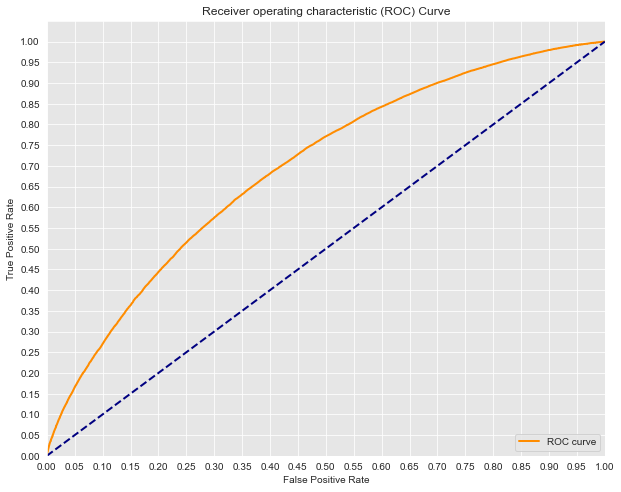

In [252]:
make_roc_curve(yc_train_score, y_train, model_type='forest')

AUC: 0.6952215353871405


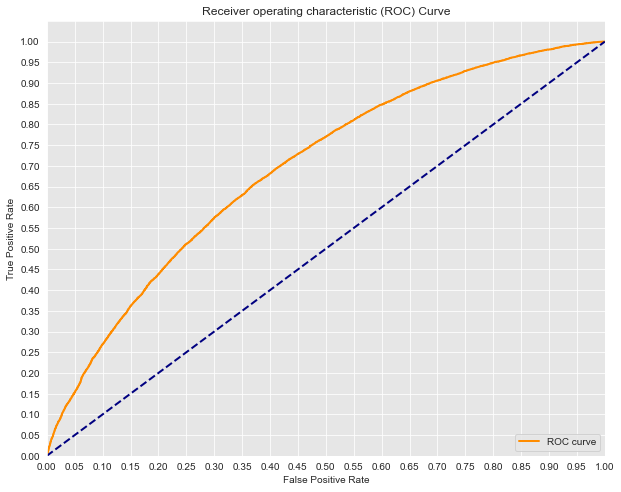

In [254]:
make_roc_curve(yc_test_score, y_test, model_type='forest')

In [276]:
prediction_for, bias_for, contributions_for = ti.predict(forest_tuned, Xc_test)

coeff for What is your age? is [0.0027926178469042835]
coeff for Number of people in household is [0.0027120801341199933]
coeff for country_italy is [0.0026135190466667893]
coeff for It is likely that I will get coronavirus (COVID-19) in the future is [0.0021622547671882497]
coeff for emp_Retired is [0.0010629632296400746]
coeff for Avoided large-sized social gatherings (more than 10 people) is [0.0005380642964009466]
coeff for I am worried about getting COVID19 is [0.00047778468286706745]
coeff for Have you had the first or second doses of a Coronavirus (COVID-19) vaccine? is [0.00023089753385438283]
coeff for country_germany is [0.00018774188926814393]
coeff for Coronavirus (COVID-19) is very dangerous for me is [0.00012139183449598923]
coeff for A vaccine for coronavirus (COVID-19) will protect me against any variants, strains or mutations of coronavirus is [7.773914257505961e-05]
coeff for I am worried about potential side effects of a COVID19 vaccine is [6.025695153865098e-05]
coe

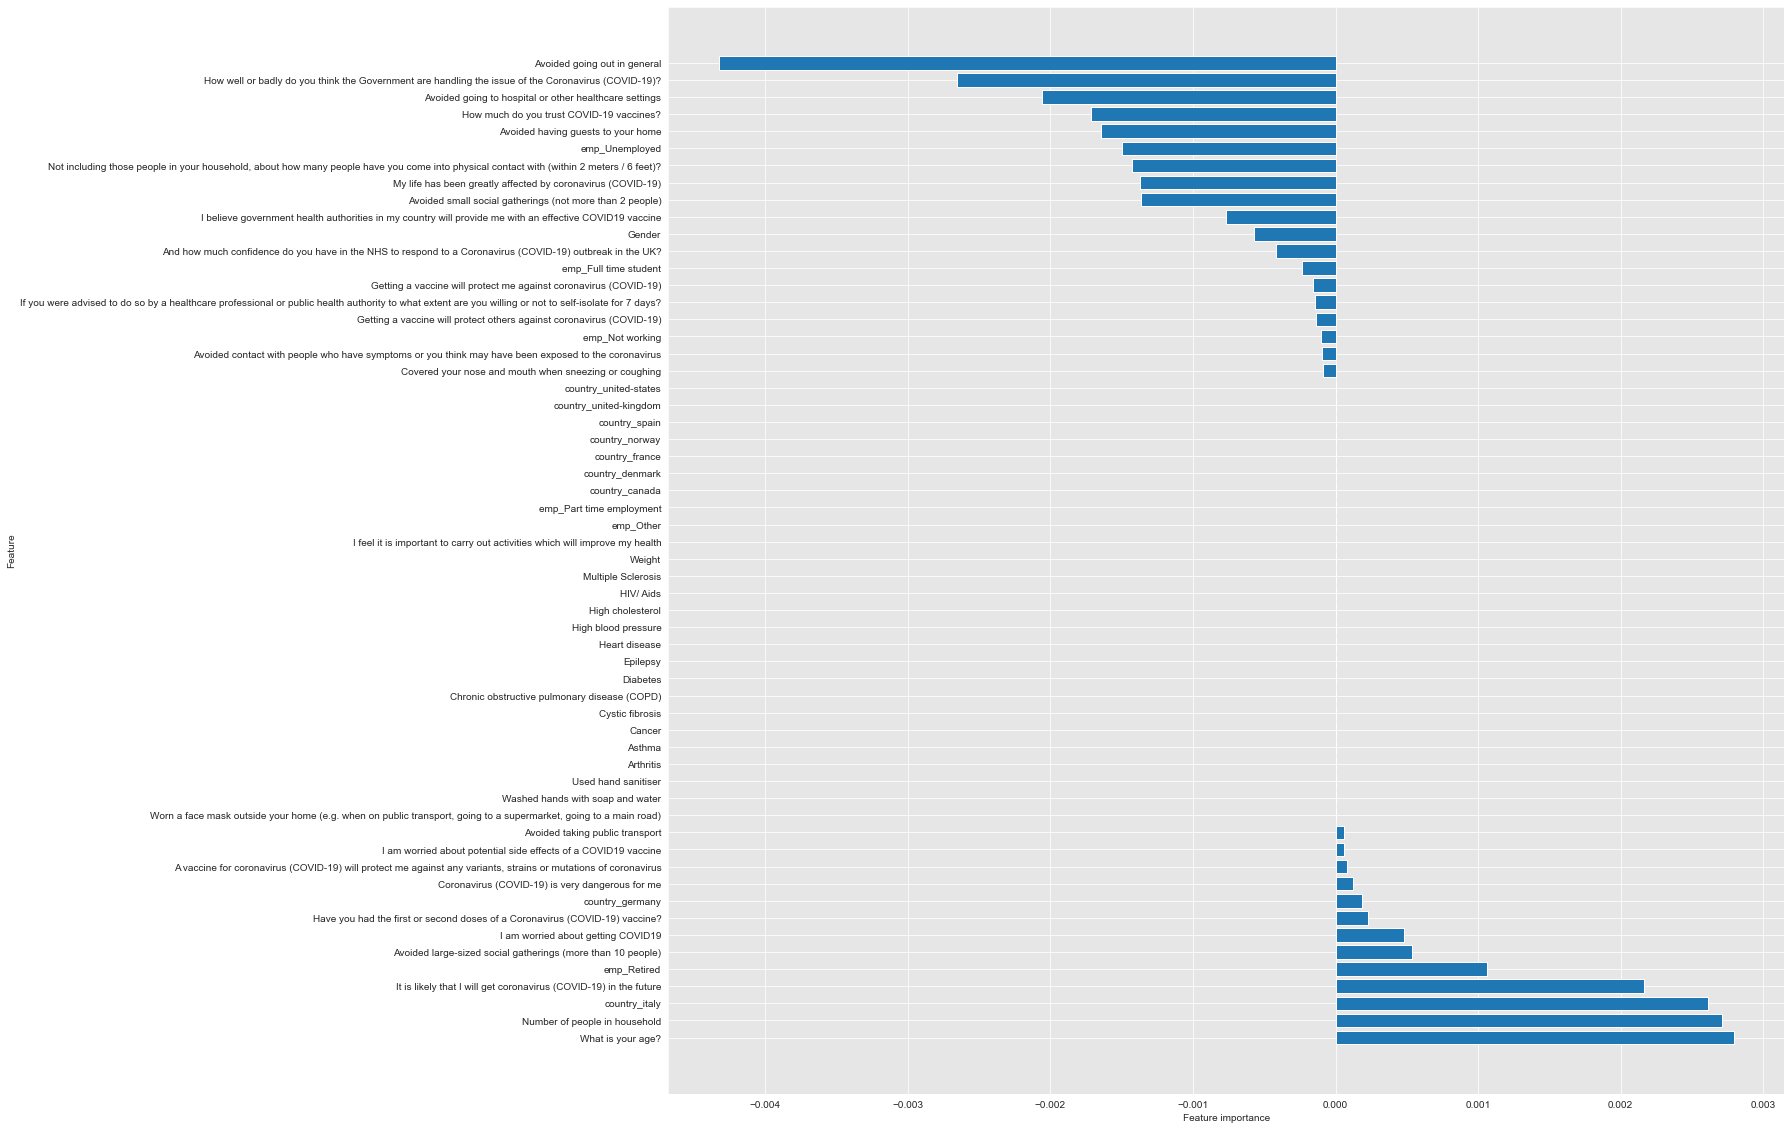

In [278]:
for_imp=important_cols(contributions_for)


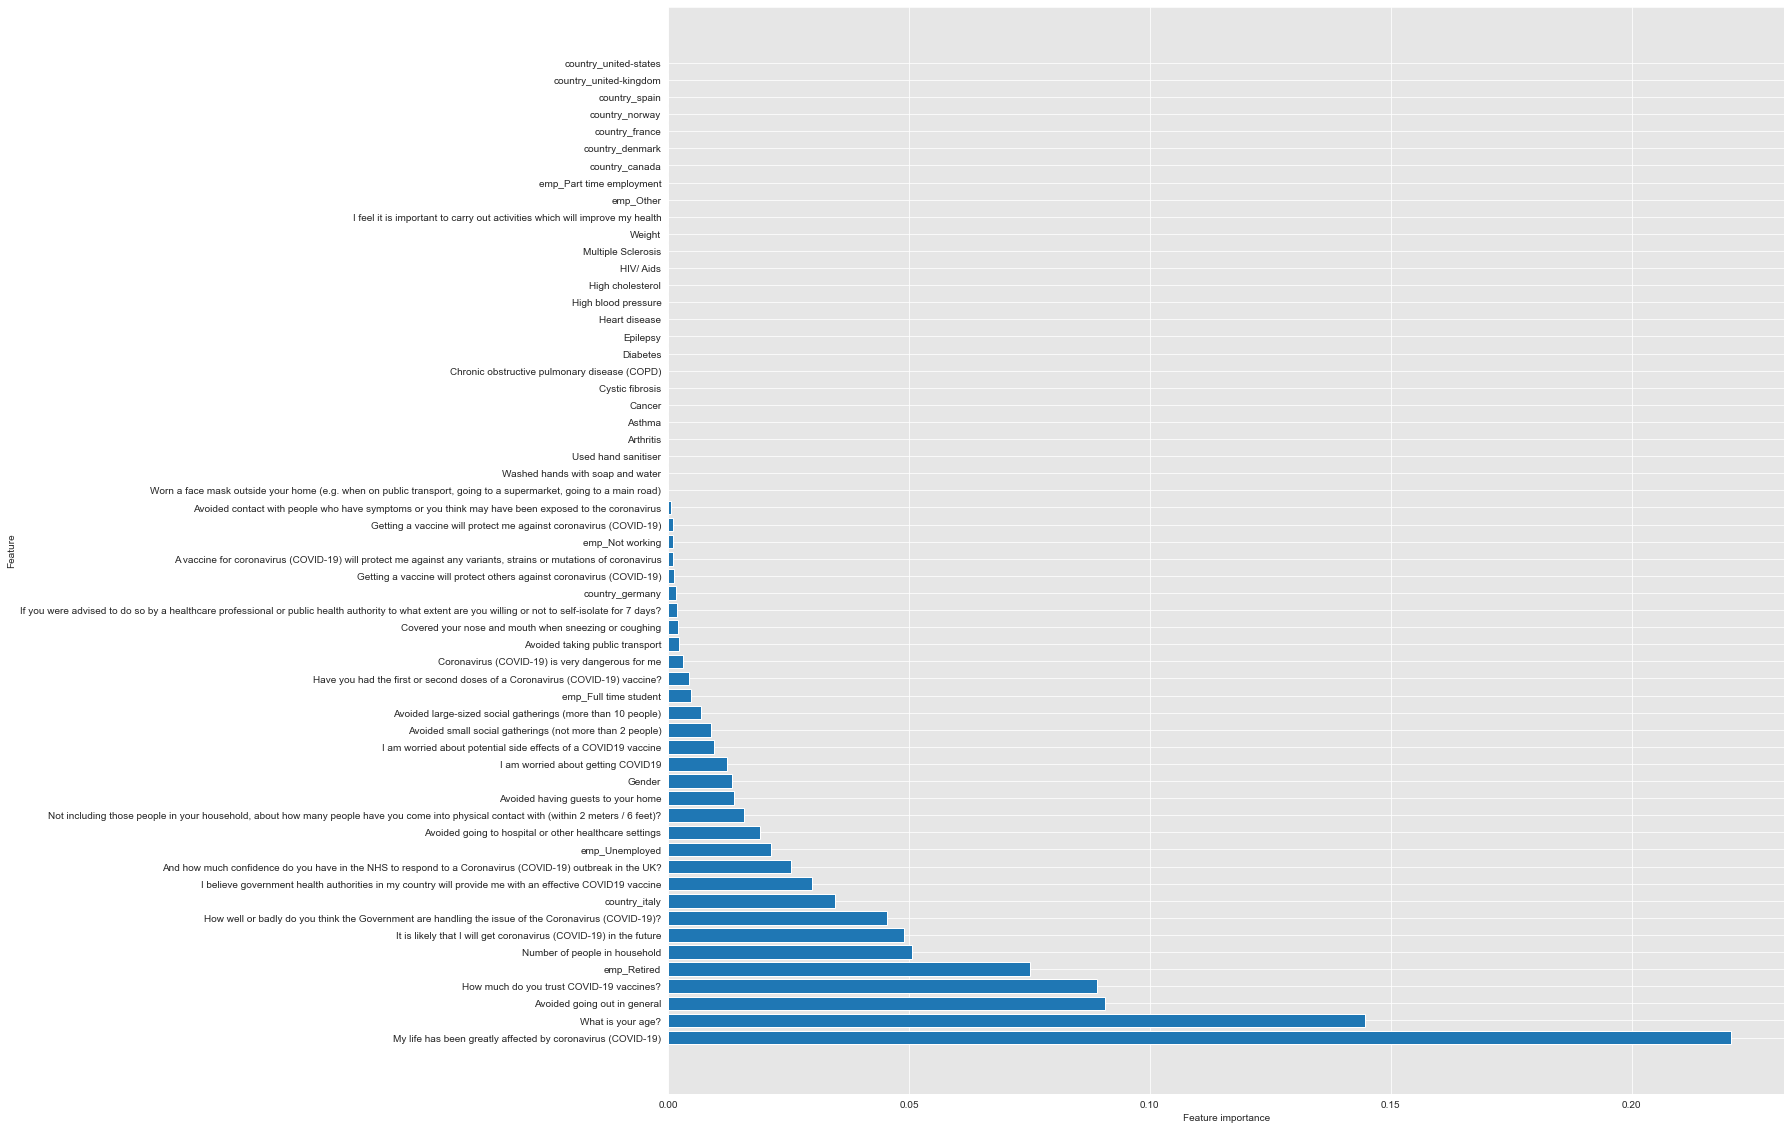

In [279]:
plot_feature_importances(forest_tuned, Xc_train, feat_lim=None)

In [335]:
explainer_for = shap.TreeExplainer(forest_tuned)
shap_val_for = explainer_for.shap_values(Xc_train)
shap_obj_for = explainer_for(Xc_train)


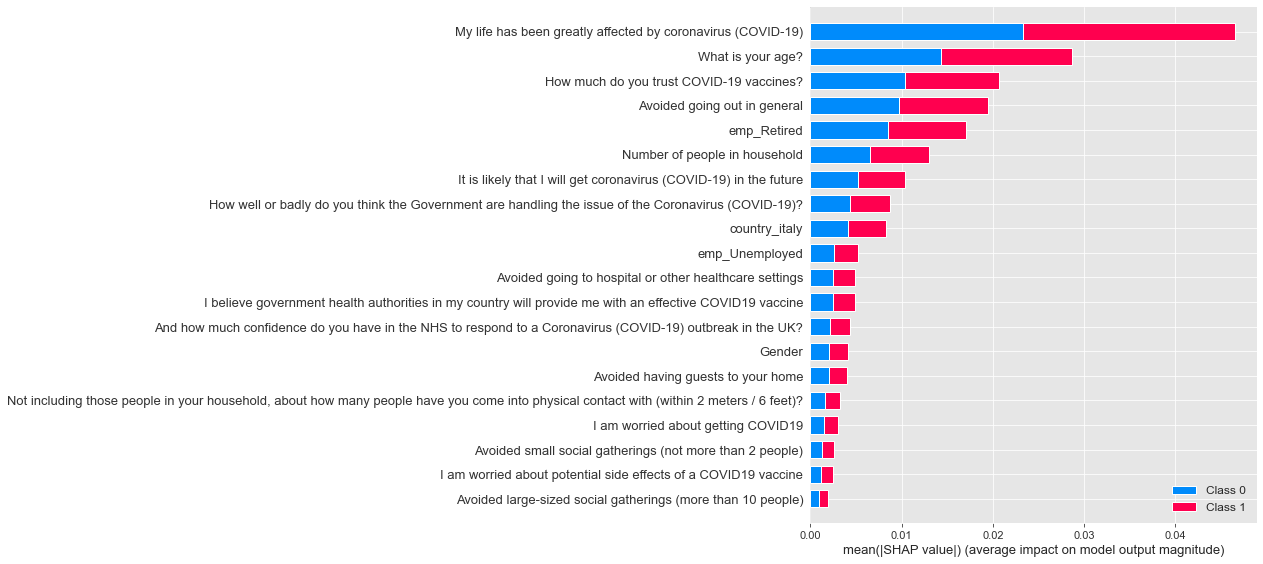

In [325]:
shap.summary_plot(shap_val_for, Xc_train, plot_type="bar")

In [355]:
shap_obj_y = shap_obj_for[:,:,0]
shap_obj_z = shap_obj_for[:,:,1]

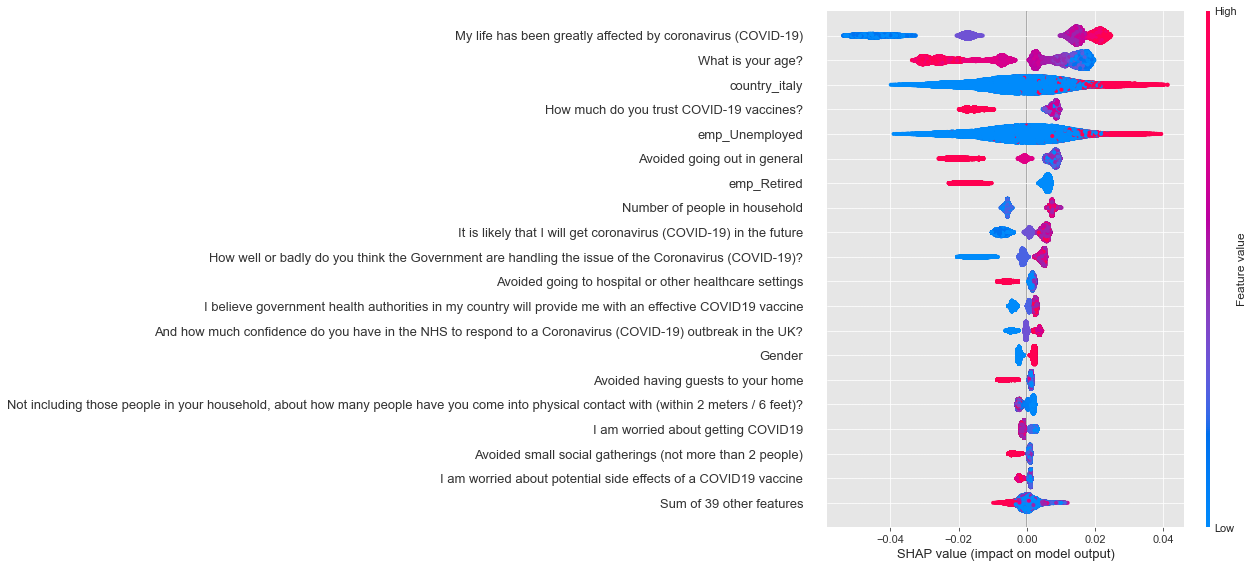

In [358]:
shap.plots.beeswarm(shap_obj_z, max_display=20)

# GBoost

In [11]:
xgb = XGBClassifier()

# Fit XGBClassifier
xgb.fit(X_train, y_train)


C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:33:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

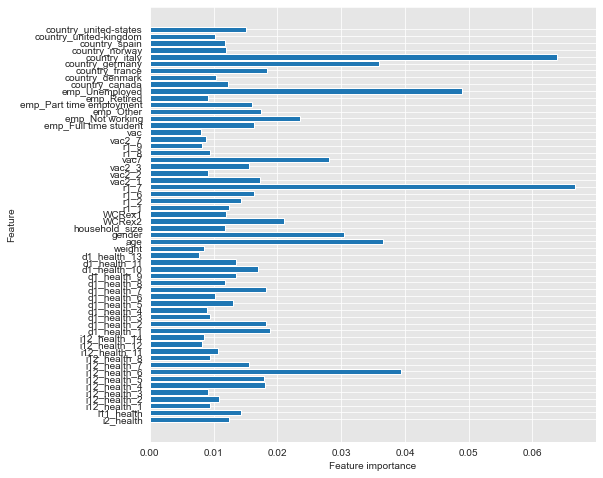

In [326]:
plot_feature_importances(xgb)

In [327]:
xgb_pred = xgb.predict(X_train)
evaluation_metrics(xgb_pred, 'train')

[[32287 13127]
 [11122 39551]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.73     45414
           1       0.75      0.78      0.77     50673

    accuracy                           0.75     96087
   macro avg       0.75      0.75      0.75     96087
weighted avg       0.75      0.75      0.75     96087



In [328]:
xgb_pred_test = xgb.predict(X_test)
evaluation_metrics(xgb_pred_test, 'test')

[[ 9747  5392]
 [ 4647 12244]]
              precision    recall  f1-score   support

           0       0.68      0.64      0.66     15139
           1       0.69      0.72      0.71     16891

    accuracy                           0.69     32030
   macro avg       0.69      0.68      0.68     32030
weighted avg       0.69      0.69      0.69     32030



In [329]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [330]:
grid_clf = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:38:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:38:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:38:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:38:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[22:41:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [332]:
xgb_gr = XGBClassifier(max_depth=6, min_child_weight=2, n_estimators=100, subsample=0.7)
setattr(xgb_gr, 'learning_rate', 0.1)

xgb_gr.fit(X_train, y_train)


[22:57:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [333]:
xgb_gr_pred = xgb_gr.predict(X_train)
evaluation_metrics(xgb_gr_pred, 'train')

[[30422 14992]
 [12581 38092]]
              precision    recall  f1-score   support

           0       0.71      0.67      0.69     45414
           1       0.72      0.75      0.73     50673

    accuracy                           0.71     96087
   macro avg       0.71      0.71      0.71     96087
weighted avg       0.71      0.71      0.71     96087



In [334]:
xgb_gr_pred_test = xgb_gr.predict(X_test)
evaluation_metrics(xgb_gr_pred_test, 'test')

[[ 9717  5422]
 [ 4582 12309]]
              precision    recall  f1-score   support

           0       0.68      0.64      0.66     15139
           1       0.69      0.73      0.71     16891

    accuracy                           0.69     32030
   macro avg       0.69      0.69      0.69     32030
weighted avg       0.69      0.69      0.69     32030



In [15]:
int_list_d=[]
for i in max_depths:
    j = int(i)
    int_list_d.append(j)
int_list_d

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

[10:48:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:48:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:48:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:48:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

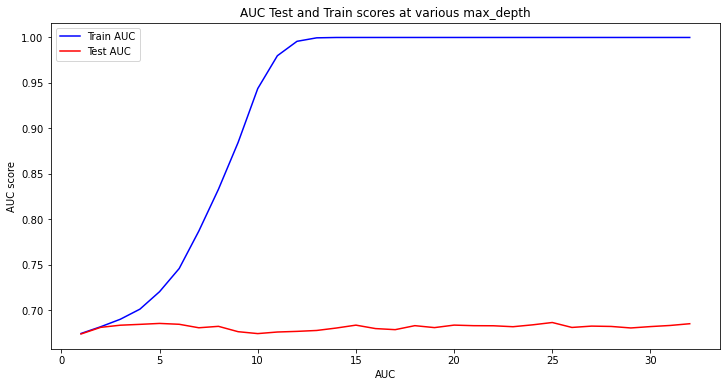

In [16]:
xgb_depth = clone(xgb)
xgb_depth.fit(X_train, y_train)
test_params(int_list_d, xgb_depth, 'max_depth', model_type='xgb')

[11:14:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:14:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:14:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:14:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

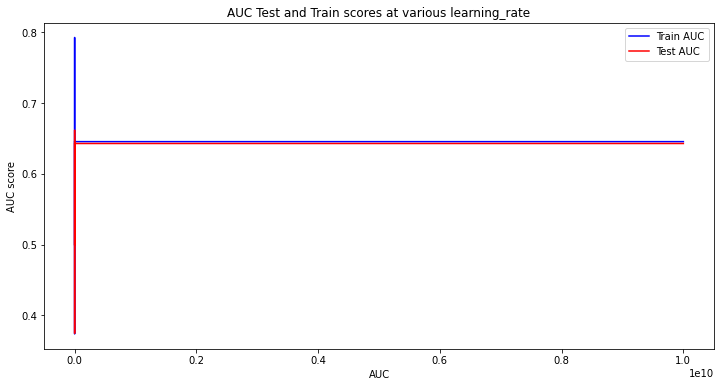

In [22]:
xgb_lrate = clone(xgb)
xgb_lrate.fit(X_train, y_train)
test_params(learning_rate_list, xgb_lrate, 'learning_rate', model_type='tree')

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:18:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

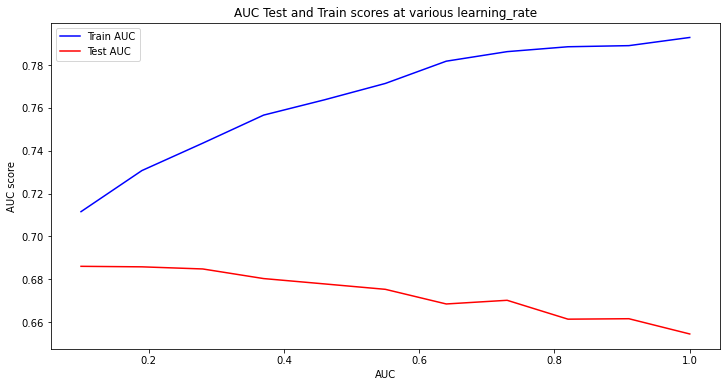

In [23]:
xgb_lrate1 = clone(xgb)
xgb_lrate1.fit(X_train, y_train)
test_params(learning_rate_list1, xgb_lrate1, 'learning_rate', model_type='tree')

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:21:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:21:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:21:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

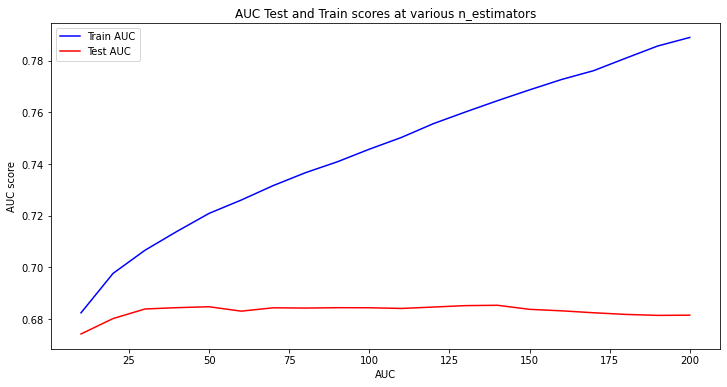

In [26]:
xgb_est = clone(xgb)
xgb_est.fit(X_train, y_train)
test_params(est_list, xgb_est, 'n_estimators', model_type='tree')

[11:40:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:41:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

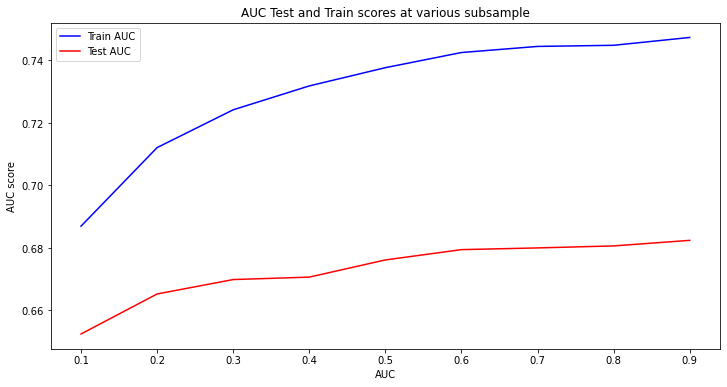

In [27]:
subs=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
xgb_subs = clone(xgb)
xgb_subs.fit(X_train, y_train)
test_params(subs, xgb_subs, 'subsample', model_type='tree')

[11:46:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:46:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:46:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:46:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

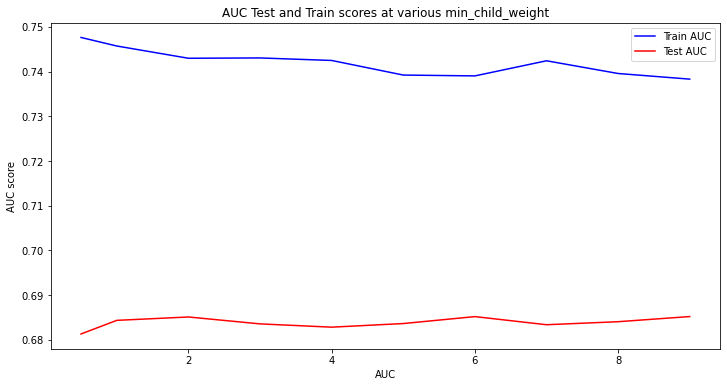

In [28]:
mcw=[0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9]
xgb_mcw = clone(xgb)
xgb_mcw.fit(X_train, y_train)
test_params(mcw, xgb_mcw, 'min_child_weight', model_type='tree')

In [31]:
param_grid_1 = {
    'learning_rate': [0.1],
    'max_depth': [2],
    'min_child_weight': [0.5, 0.7, 1],
    'subsample': [0.2, 0.5, 0.7],
    'n_estimators': [20, 35, 50],
}

In [32]:
grid_clf = GridSearchCV(xgb, param_grid_1, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

C:\Users\james\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:54:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[11:54:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[11:55:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[11:55:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[11:56:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [175]:
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

In [201]:
X_train_codes=X_train.copy()
X_test_codes=X_test.copy()
X_train_codes.rename(columns=code_dict, inplace=True)
X_test_codes.rename(columns=code_dict, inplace=True)

d_train = xgboost.DMatrix(X_train_codes, label=y_train)
d_test = xgboost.DMatrix(X_test_codes, label=y_test)

In [202]:
X_train_codes

Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?  \
87942                                                 7.0                                                                                          
9407                                                  9.0                                                                                          
81398                                                 3.0                                                                                          
27485                                                30.0                                                                                          
44622                                                50.0                                                                                          
...                                                   ...                                                                                          
105386                                                0.0                                                                                          
34286                                                 4.0                                                                                          
124811                                                6.0                                                                                          
92976                                                 1.0                                                                                          
58504                                               217.0                                                                                          

        If you were advised to do so by a healthcare professional or public health authority to what extent are you willing or not to self-isolate for 7 days?  \
87942                                                   0                                                                                                        
9407                                                    1                                                                                                        
81398                                                   0                                                                                                        
27485                                                   1                                                                                                        
44622                                                   1                                                                                                        
...                                                   ...                                                                                                        
105386                                                  1                                                                                                        
34286                                                   0                                                                                                        
124811                                                  0                                                                                                        
92976                                                   0                                                                                                        
58504                                                   0                                                                                                        

        Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)  \
87942                                                   0                                                                  
9407                                  

In [203]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model1 = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.69049
[100]	test-logloss:0.62947
[200]	test-logloss:0.60923
[300]	test-logloss:0.59941
[400]	test-logloss:0.59385
[500]	test-logloss:0.59028
[600]	test-logloss:0.58801
[700]	test-logloss:0.58642
[800]	test-logloss:0.58531
[900]	test-logloss:0.58440
[1000]	test-logloss:0.58376
[1100]	test-logloss:0.58324
[1200]	test-logloss:0.58282
[1300]	test-logloss:0.58256
[1400]	test-logloss:0.58226
[1500]	test-logloss:0.58197
[1600]	test-logloss:0.58179
[1700]	test-logloss:0.58166
[1733]	test-logloss:0.58163


In [204]:
model_pred1=model1.predict(d_test)

In [205]:
model_pred1

array([0.08211892, 0.3515633 , 0.38852733, ..., 0.71704394, 0.41497406,
       0.18721732], dtype=float32)

In [206]:
mp_list=[]
for mp in model_pred1:
    if mp >=0.5:
        mp_list.append(1)
    else:
        mp_list.append(0)
mp_list

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [208]:
evaluation_metrics(mp_list, y_test)

[[ 9762  5377]
 [ 4512 12379]]
              precision    recall  f1-score   support

           0       0.68      0.64      0.66     15139
           1       0.70      0.73      0.71     16891

    accuracy                           0.69     32030
   macro avg       0.69      0.69      0.69     32030
weighted avg       0.69      0.69      0.69     32030



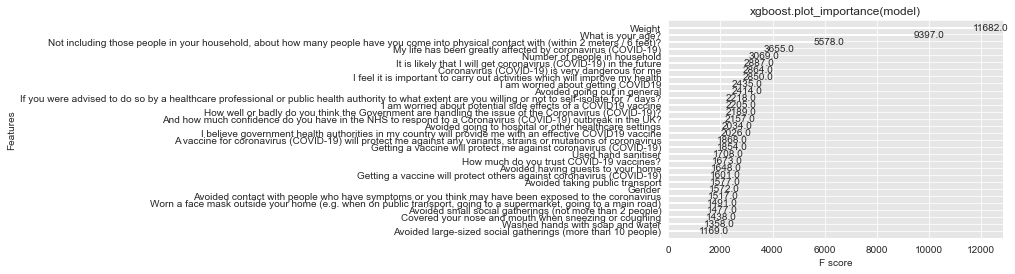

In [211]:
xgboost.plot_importance(model1, max_num_features=30)
pl.title("xgboost.plot_importance(model)")
pl.show()

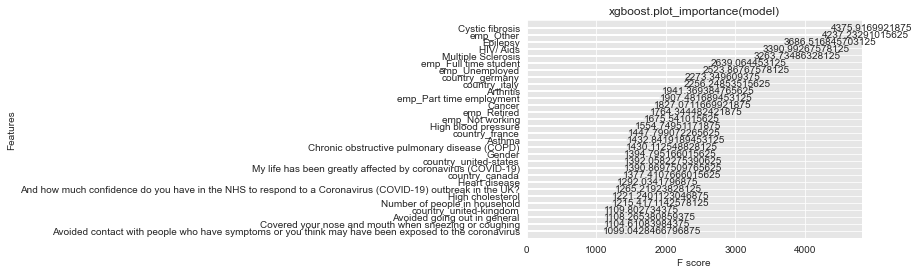

In [212]:
xgboost.plot_importance(model1, importance_type="cover", max_num_features=30)
pl.title("xgboost.plot_importance(model)")
pl.show()

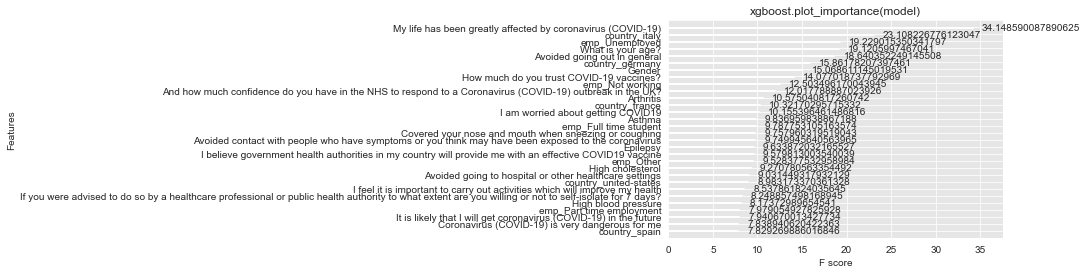

In [213]:
xgboost.plot_importance(model1, importance_type="gain", max_num_features=30)
pl.title("xgboost.plot_importance(model)")
pl.show()

In [214]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [234]:
shap_values

array([[-0.00075976, -0.0764238 , -0.01621906, ..., -0.01334655,
        -0.00103616,  0.01175645],
       [ 0.13426396, -0.05245937, -0.02866643, ..., -0.01354601,
        -0.00228965,  0.01113167],
       [ 0.07247884, -0.05582078,  0.03486734, ..., -0.00492175,
        -0.01416337,  0.0169435 ],
       ...,
       [-0.11703806, -0.05515026,  0.03140101, ..., -0.00234746,
        -0.0133966 , -0.25597697],
       [ 0.03091423, -0.07102424, -0.01198939, ..., -0.01709476,
        -0.00307357, -0.27825698],
       [-0.19020179,  0.09601605,  0.05442014, ..., -0.00454402,
        -0.00428961, -0.16864464]], dtype=float32)

In [217]:
shap.initjs()

In [218]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [107]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])


NameError: name 'explainer' is not defined

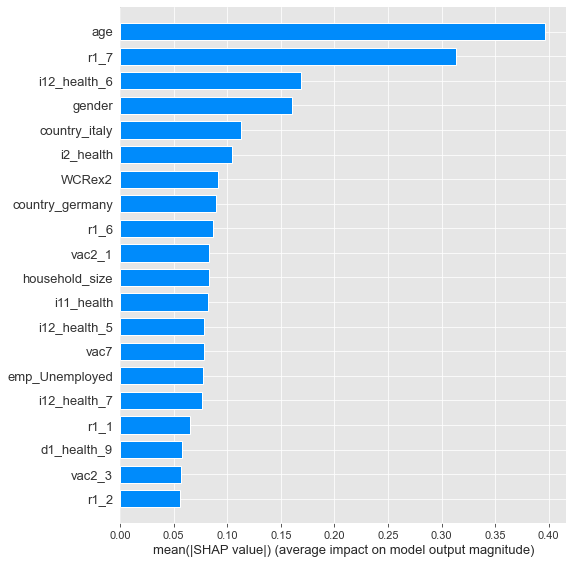

In [220]:
shap.summary_plot(shap_values, X, plot_type="bar")

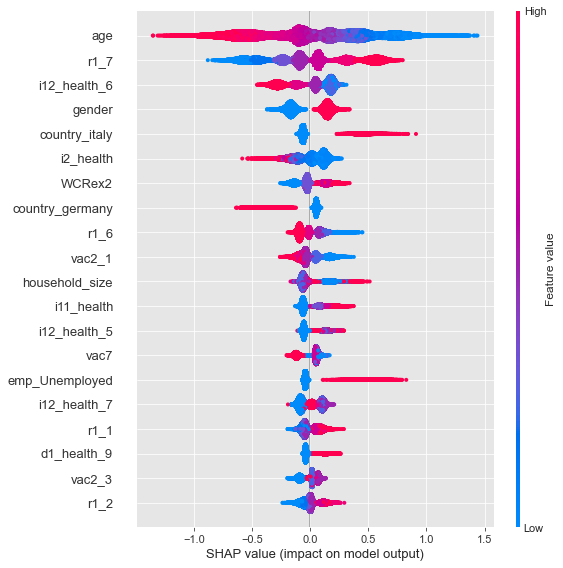

In [221]:
shap.summary_plot(shap_values, X)

In [222]:
# train final model on the full data set
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model_ind = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.68988
[100]	test-logloss:0.63308
[200]	test-logloss:0.61825
[300]	test-logloss:0.61028
[400]	test-logloss:0.60523
[500]	test-logloss:0.60189
[600]	test-logloss:0.59936
[700]	test-logloss:0.59766
[800]	test-logloss:0.59623
[900]	test-logloss:0.59523
[1000]	test-logloss:0.59443
[1100]	test-logloss:0.59383
[1200]	test-logloss:0.59335
[1300]	test-logloss:0.59303
[1400]	test-logloss:0.59278
[1500]	test-logloss:0.59254
[1600]	test-logloss:0.59233
[1688]	test-logloss:0.59225


In [223]:
shap_values_ind = shap.TreeExplainer(model_ind).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


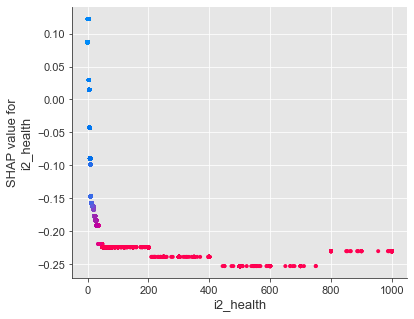

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


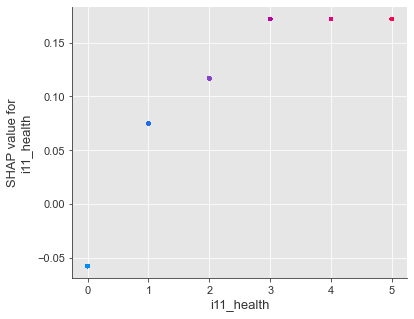

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


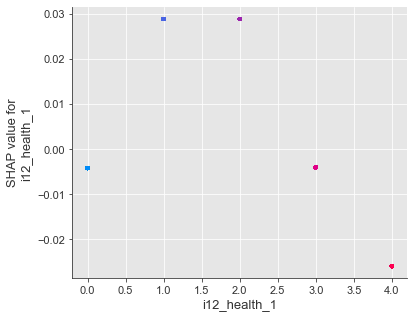

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


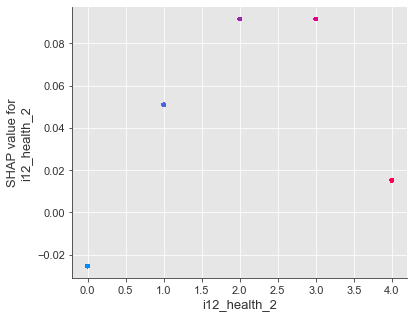

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


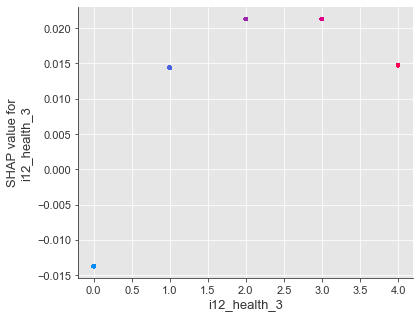

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


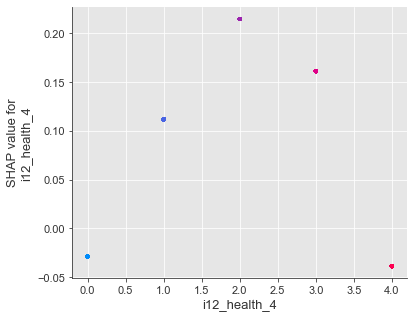

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


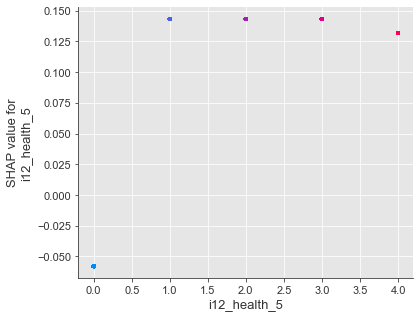

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


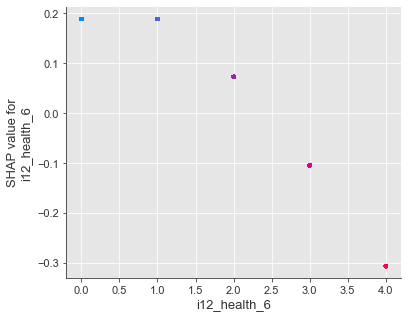

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


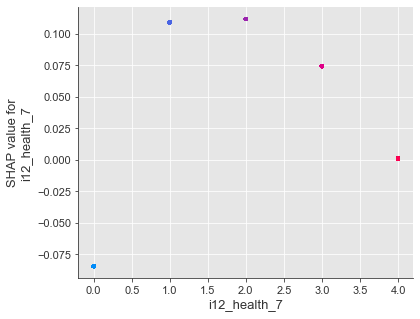

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


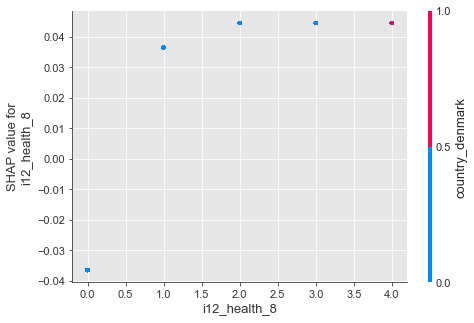

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


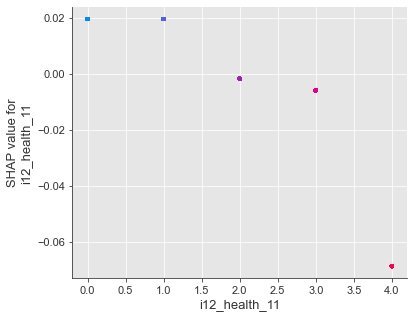

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


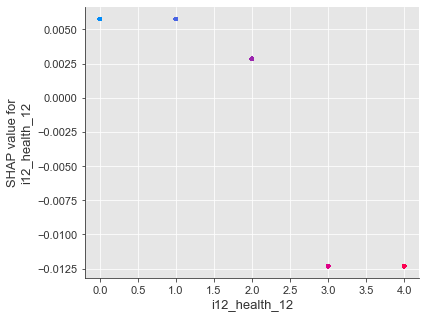

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


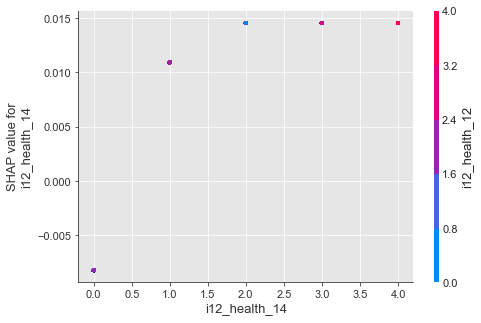

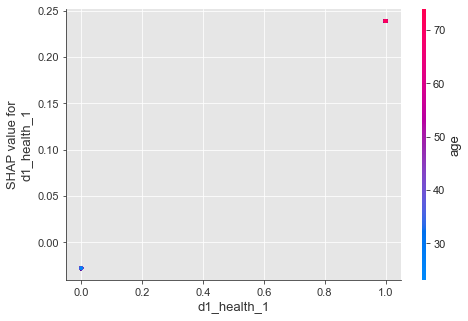

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


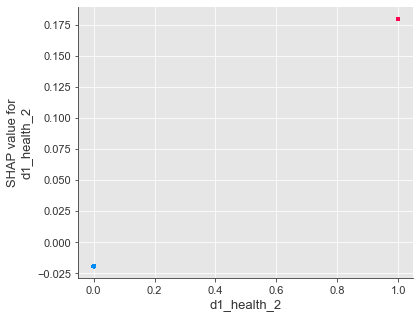

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


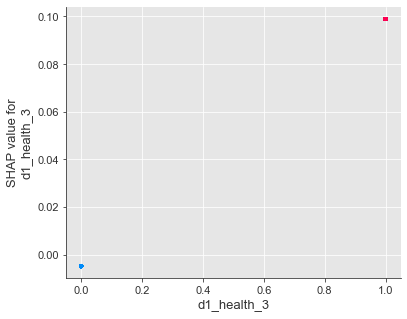

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


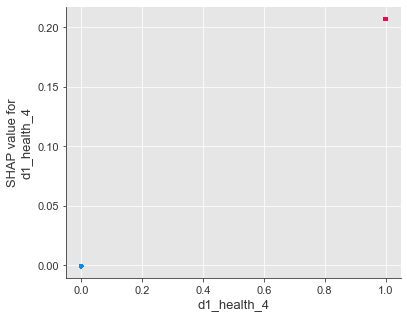

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


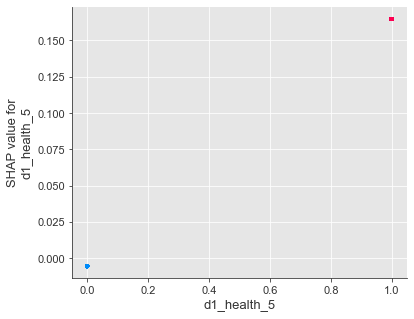

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


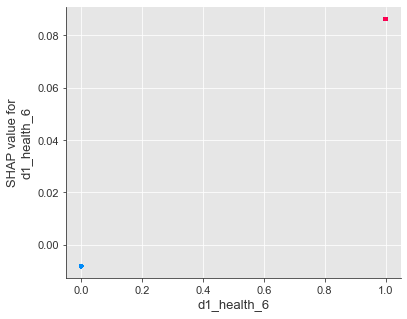

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


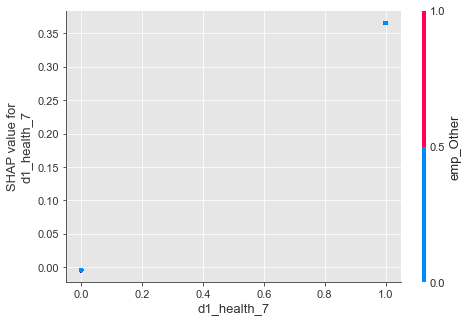

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


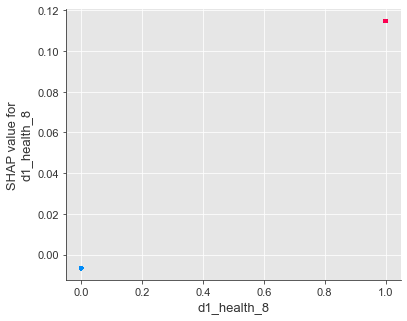

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


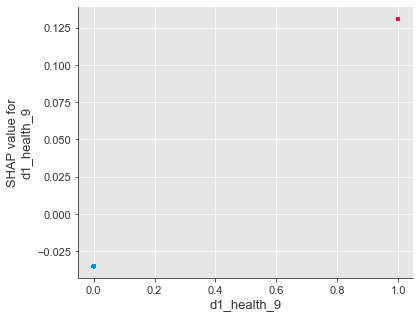

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


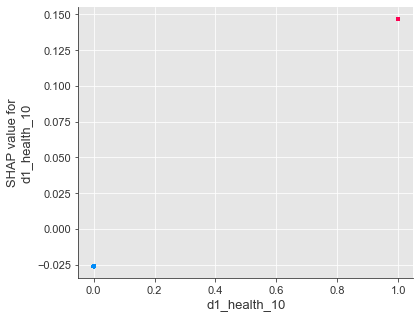

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


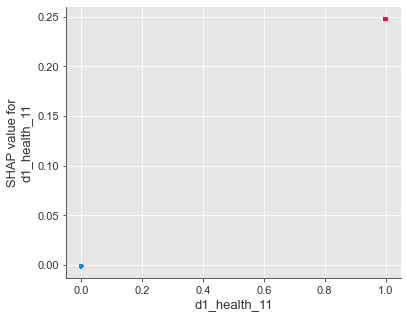

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


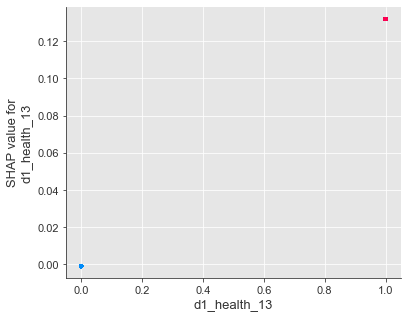

invalid value encountered in true_divide
invalid value encountered in true_divide


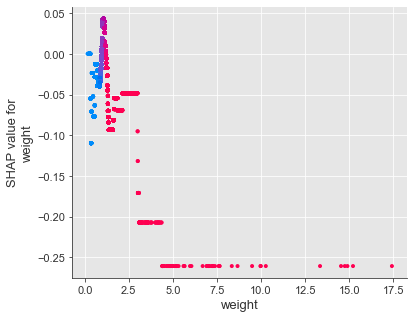

invalid value encountered in true_divide
invalid value encountered in true_divide


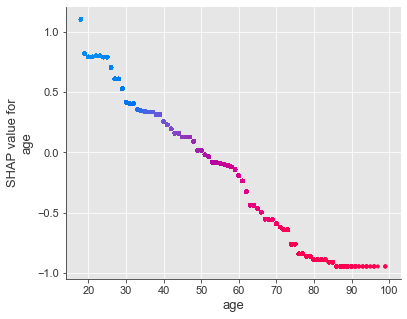

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


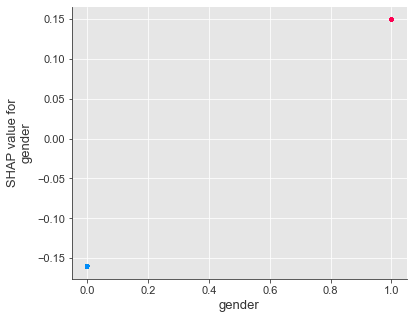

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


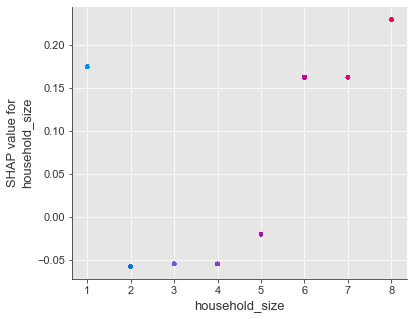

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


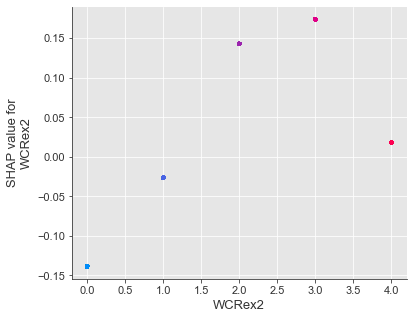

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


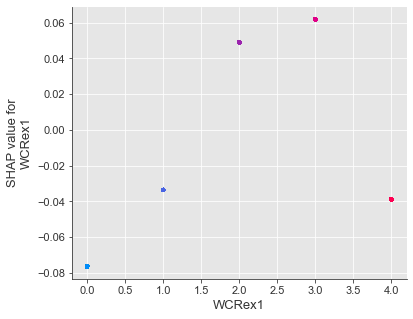

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


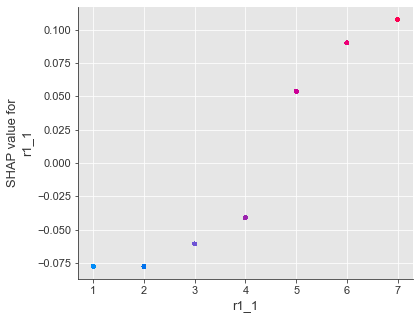

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


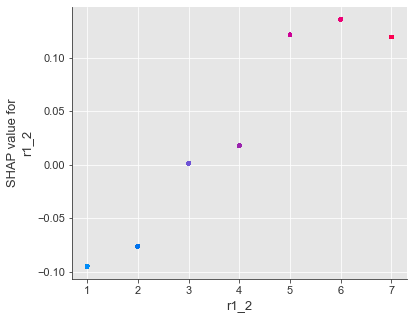

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


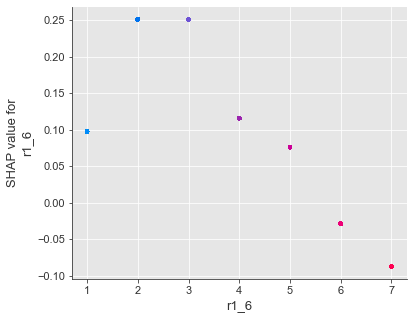

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


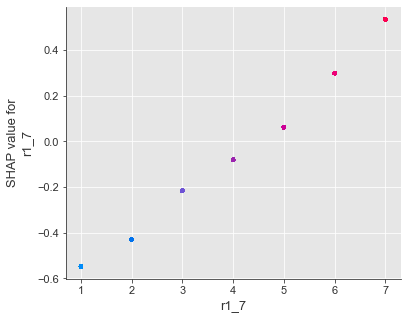

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


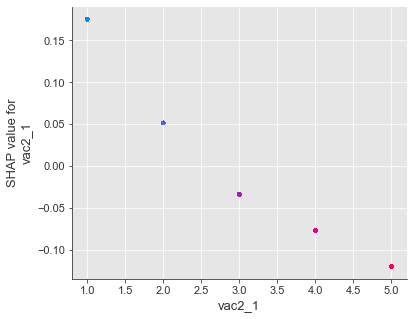

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


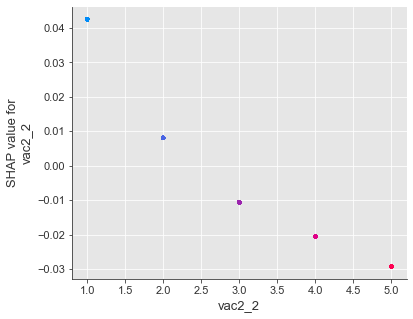

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


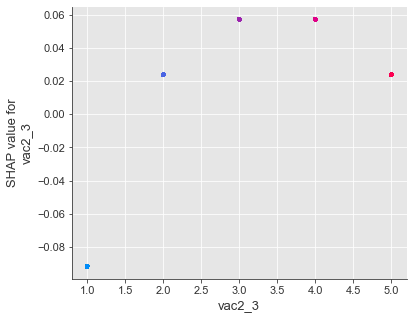

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


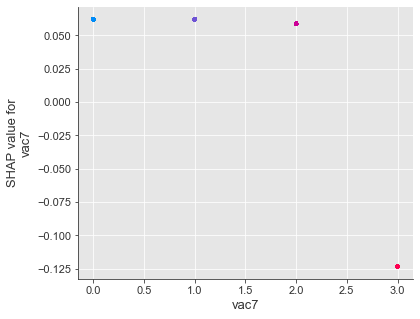

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


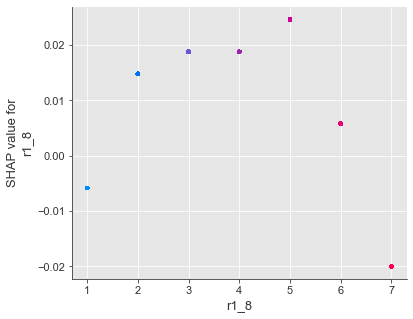

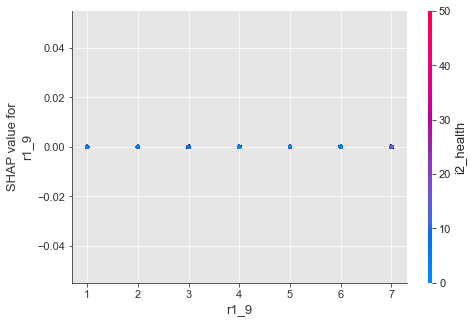

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


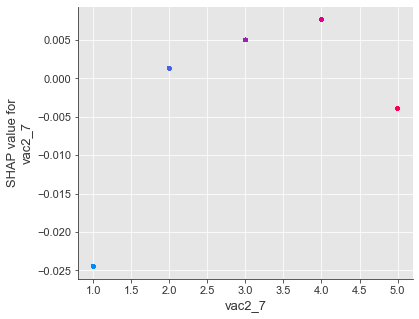

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


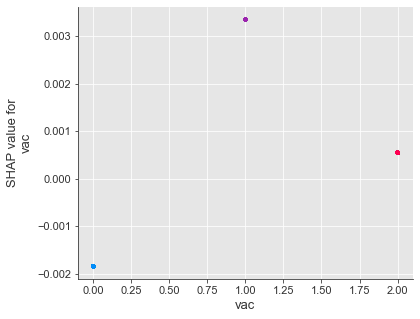

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


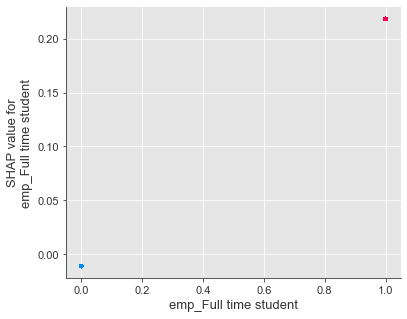

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


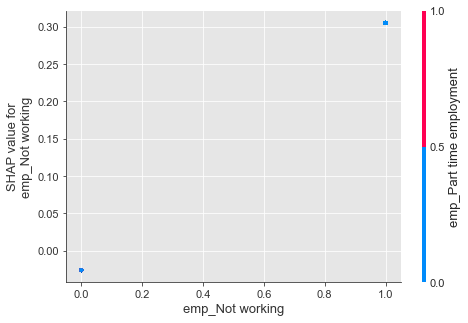

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


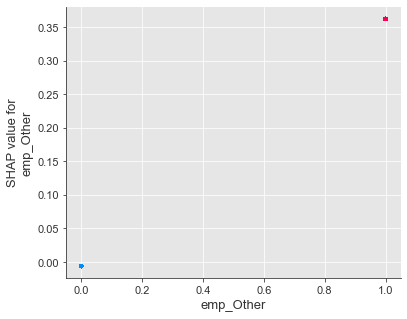

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


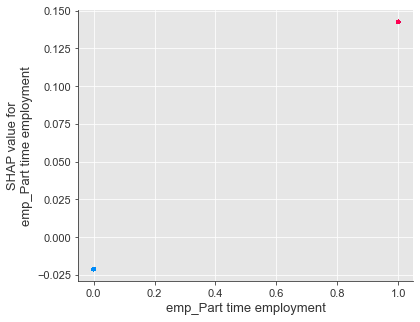

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


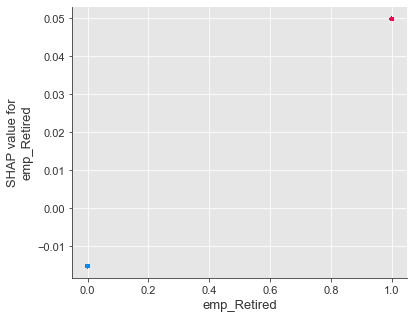

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


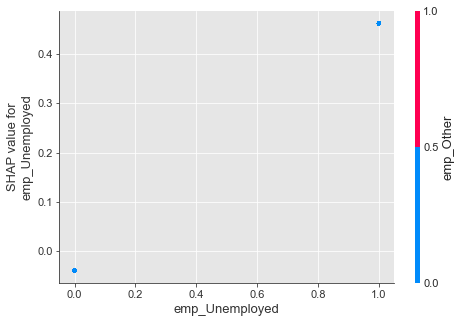

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


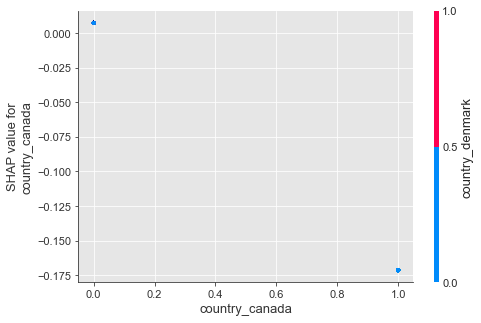

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


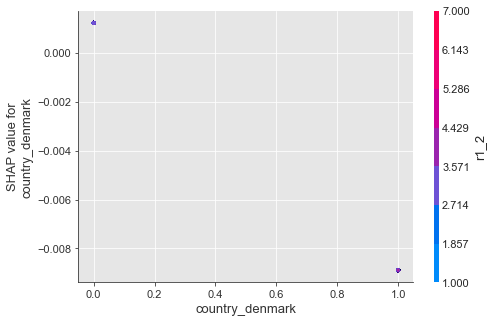

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


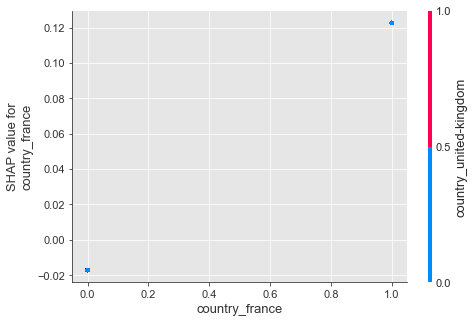

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


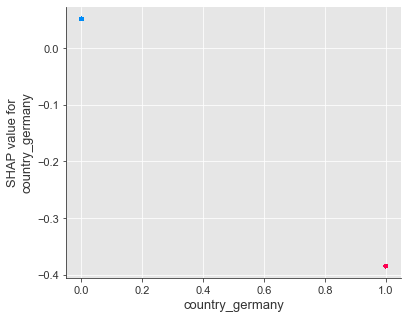

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


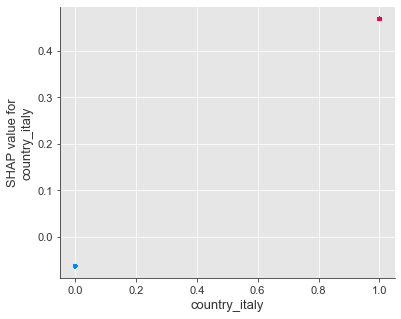

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


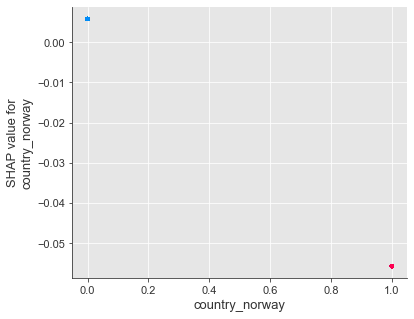

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


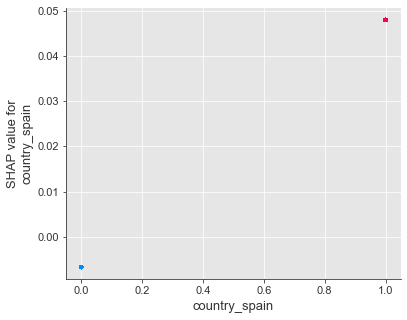

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


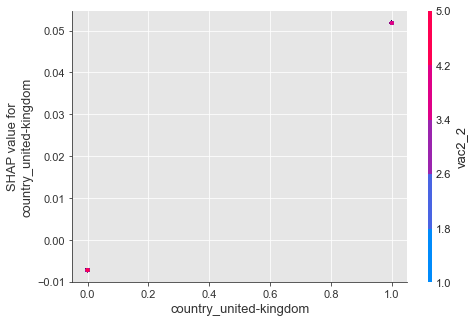

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


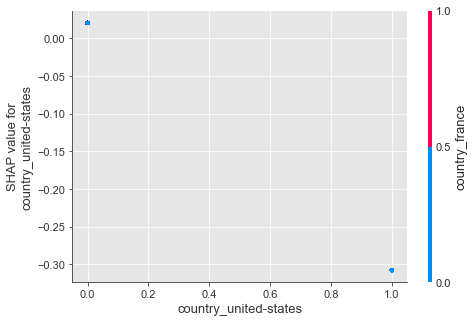

In [226]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values_ind, X, display_features=X)

In [227]:
two_df['weight'].describe()

count    128117.000000
mean          0.999028
std           0.239111
min           0.155735
25%           0.917747
50%           0.974459
75%           1.046676
max          17.428809
Name: weight, dtype: float64

In [228]:
X,y = c

In [230]:
y


array([False, False, False, ..., False, False,  True])

In [233]:
print(len(shap.datasets.adult(display=False)))

2


In [290]:
df_test=pd.DataFrame(np.linspace(0,100,100))

In [291]:
df_test

0
0     0.000000
1     1.010101
2     2.020202
3     3.030303
4     4.040404
..         ...
95   95.959596
96   96.969697
97   97.979798
98   98.989899
99  100.000000

[100 rows x 1 columns]

In [299]:
model = scaler.fit(df_test)
scaled_data = list(model.transform(df_test))

In [304]:
mean_col=np.mean(df_test[0].tolist())
std_col=np.std(df_test[0].tolist())
std_col

29.157646512850626

In [306]:
for x in list(scaled_data):
    ans=int((x*std_col)+mean_col)
    print(ans)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
100
